# Lab1: Efficient AI Fundamentals

In this lab, you will learn the foundational concepts of efficient AI through hands-on analysis of an LLM decoder layer.

## Learning Objectives

By the end of this lab, you will be able to:

1. **Measure latency, calculate MAC/FLOPs, and compute I/O cost** for your deep learning algorithms
2. **Use roofline models** to identify performance bottlenecks (compute or I/O)
3. **Profile kernel launches on GPU** using PyTorch Profiler
4. **Understand kernel launch overhead** and optimization techniques (kernel fusion, torch.compile, CUDA Graphs)
5. **Analyze Flash Attention** and explain why it's faster

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, ProfilerActivity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional
import warnings
import math
warnings.filterwarnings('ignore')

# Our utility functions
import sys
sys.path.insert(0, '.')
from utils import *

# Check GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = torch.device("cpu")


PyTorch version: 2.5.1+cu124
CUDA available: True
GPU: NVIDIA RTX A6000
GPU Memory: 50.9 GB


# Part 1: Fundamental Metrics — Latency, MAC, and I/O

In this section, we will learn three fundamental metrics: latency, MAC, and I/O. We will start with the most common operator, matrix/vector multiplication.

#### Question 1.1 (5 points)

Please write a tri-loop version of matrix multiplication (please don't use any libraries such as Numpy, Scipy, and PyTorch API for this question)

In [4]:
def gemm(A, B):
    """
    Args:
        A (torch.Tensor): Input matrix shaped (N, K) on any device/dtype.
        B (torch.Tensor): Input matrix shaped (K, M) on the same device/dtype as A.
    Returns:
        torch.Tensor: Product matrix C with shape (N, M) stored on A/B's device and dtype.
    """
    # YOUR CODE HERE
    assert A.shape[1] == B.shape[0]
    C = [[0 for i in range(B.shape[1])] for j in range(A.shape[0])]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                C[i][j] += A[i][k] * B[k][j]
    return C


## 1.1 Latency

As simple as it means, latency refers to how long your program takes to execute on your device. It is a basic yet important metric for efficiency evaluation. Below is a standard way to measure latency on GPU. Below is code for evaluating a function execution one time.

In [5]:
def latency_one_time(fn, *args, **kwargs):
    """
    Args:
        fn (Callable): Target function to be timed once.
        *args: Positional arguments forwarded to fn.
        **kwargs: Keyword arguments forwarded to fn.
    Returns:
        None: Timing side effect only; elapsed time is stored in a local variable.
    """
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    # Start recording
    start.record()
    # Do your stuff here
    fn(*args, **kwargs)
    # End recording
    end.record()
    # Call torch.cuda.synchronize() to wait for all the previous operations to finish
    torch.cuda.synchronize()
    # Get the elapsed time
    elapsed_time = start.elapsed_time(end)
    return elapsed_time

In [6]:
gemm_latency_list = []
for i in range(20):
    A = torch.randn(64, 64, dtype=torch.float32, device=device)
    B = torch.randn(64, 64, dtype=torch.float32, device=device)
    gemm_latency_list.append(latency_one_time(gemm,A,B))
print(gemm_latency_list)

[3825.773681640625, 3802.507080078125, 3830.031005859375, 3817.2021484375, 3824.09912109375, 3820.546142578125, 3789.47900390625, 3882.4599609375, 3839.500244140625, 3824.132080078125, 3849.12841796875, 3796.792236328125, 3773.39404296875, 3805.35400390625, 3789.203857421875, 3800.84375, 3810.7314453125, 3792.339111328125, 3806.97119140625, 3793.1220703125]


#### Question 1.2 (5 points)

Please measure the latency of your `gemm` multiple times. Describe your findings.

**Your Answer:** 

>The latency measurements show significant variation across runs, ranging from ~3773ms to ~3882ms for a 64×64 matrix multiplication. While the values are relatively consistent (within ~3% variance), this demonstrates that single measurements are unreliable due to factors like GPU warmup, memory caching, and scheduling variability. This is why proper benchmarking requires warmup runs and averaging multiple iterations to get stable, representative measurements.

Based on your findings, you will realize that evaluating the function one time is highly unreliable. Therefore, the standard way to measure latency is to warmup the program then measure the average latency of multiple runs. The code is shown below.

In [7]:
def latency(fn, *args, warmup = 10, repeat = 100, **kwargs):
    """
    Args:
        fn (Callable): Target function to be benchmarked.
        *args: Positional inputs forwarded to fn.
        warmup (int): Number of warmup invocations to stabilize kernels.
        repeat (int): Number of timed iterations to average.
        **kwargs: Keyword inputs forwarded to fn.
    Returns:
        float: Mean latency in seconds computed from CUDA event timings.
    """

    # Warmup the function for the number of 'warmup' times. Make sure to call `torch.cuda.synchronize()` at the end of warmup.

    for _ in range(warmup):
        fn(*args, **kwargs)
    torch.cuda.synchronize()

    # Measure the time of each execution for the number of 'repeat' times. Record the time of each execution in the 'times' list.
    times = []

    for _ in range(repeat):
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        fn(*args, **kwargs)
        end.record()
        # Don't forget to synchronize the device
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    # Return the average time of the repeated executions in seconds
    times = torch.tensor(times)
    return times.mean().item() / 1000

Now, let's see the latency of matrix-matrix and matrix-vector multiplication (this could take some time)

In [5]:
a = torch.randn(64, 64, dtype=torch.float32, device=device)
b = torch.randn(64, 64, dtype=torch.float32, device=device)
v = torch.randn(64, 1, dtype=torch.float32, device=device)
gemm_latency = latency(gemm, a, b, warmup=3, repeat=10)
gemv_latency = latency(gemm, a, v, warmup=3, repeat=10)
print("gemm_latency", gemm_latency)
print("gemv_latency", gemv_latency)

gemm_latency 10.0527412109375
gemv_latency 0.15698965454101563


As you can see, the most naive matrix multiplication is very slow even for small matrices. This is because the tri-loop is highly inefficient and doesn't make use of the modern hardware (no parallelism so not suitable for GPU). In fact, there's still a lot of room for improvement. For example, `torch.matmul` is highly optimized for matrix multiplication. You can refer to resources such as [NVIDIA CUTLASS](https://github.com/NVIDIA/cutlass) and [Triton matmul kernel](https://triton-lang.org/main/getting-started/tutorials/03-matrix-multiplication.html) if you are interested in how matmul is optimized on modern GPUs. Please run the cell below to feel the power of optimization.

Completed for size: 64
Completed for size: 128
Completed for size: 256
Completed for size: 512
[10.505083984375, 81.7921953125, 630.09975, 4996.246]
[6.429439783096314e-05, 6.45247995853424e-05, 6.519679725170136e-05, 7.272319495677948e-05]


<Axes: xlabel='Matrix dimension (N)', ylabel='Latency (ms)'>

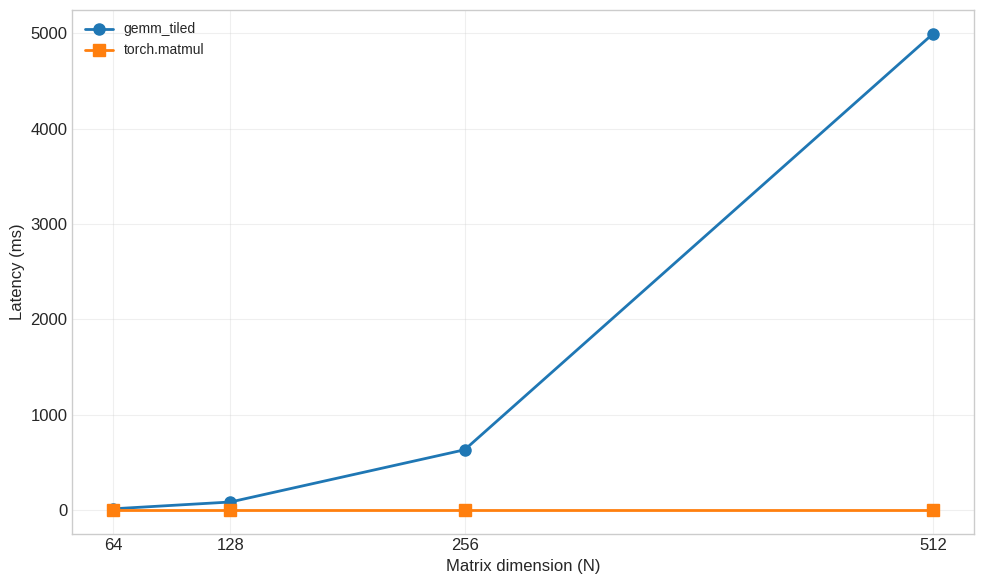

In [6]:
sizes = [64, 128, 256, 512]
gemm_tiled_latencies = []
torch_matmul_latencies = []
for size in sizes:
    a = torch.randn(size, size, dtype=torch.float32, device=device)
    b = torch.randn(size, size, dtype=torch.float32, device=device)
    gemm_tiled_latencies.append(latency(gemm, a, b, warmup=2, repeat=5))
    torch_matmul_latencies.append(latency(torch.matmul, a, b, warmup=2, repeat=5))
    print(f"Completed for size: {size}")
    del a, b
    torch.cuda.empty_cache()

print(gemm_tiled_latencies)
print(torch_matmul_latencies)
plot_gemm_torch_matmul_latency(sizes, gemm_tiled_latencies, torch_matmul_latencies)


## Part 1.2: MAC & FLOPs

**Multiply-Accumulate (MAC)** operation is a fundamental building block in digital signal processing and artificial intelligence hardware. It computes the product of two numbers and adds that result to an accumulating sum, effectively performing the operation $a \leftarrow a + (b \times c)$. This single-cycle instruction is critical because it forms the basis of dot products and matrix multiplications, which are the primary mathematical engines behind neural networks.

**FLOPs (Floating Point Operations)** count the total number of individual arithmetic operations involving decimal numbers. These operations include addition, subtraction, multiplication, and division.

Based on the above definitions, you can see that 1 MAC consists of 2 FLOPs (1 for multiplication and 1 for addition).


#### Question 1.3 (5 points)

Please calculate the MAC of your matrix multiplication

In [10]:
def gemm_mac(x, y):
    """
    Args:
        x (torch.Tensor): Left matrix shaped (N, K).
        y (torch.Tensor): Right matrix shaped (K, M).
    Returns:
        int: Multiply-accumulate count for computing x @ y.
    """
    # YOUR CODE HERE
    assert x.shape[1] == y.shape[0]
    N = x.shape[0]
    K = x.shape[1]
    M = y.shape[1]
    return N * K * M


In [11]:
# Public Testcase
A = torch.randn(512, 512, dtype=torch.float32, device=device)
B = torch.randn(512, 512, dtype=torch.float32, device=device)
assert gemm_mac(A, B) == 134217728

A = torch.randn(512, 256, dtype=torch.float32, device=device)
B = torch.randn(256, 512, dtype=torch.float32, device=device)
assert gemm_mac(A, B) == 67108864

## Part 1.3: I/O

I/O, which is memory access, consists of the following parts:
- **Read**: Loading weights and input activations from HBM
- **Write**: Storing output activations to HBM
Thus, the I/O cost of one operation is simply the total memory bytes read plus the total memory bytes written.

#### Question 1.4 (5 points)

Finish the code below to compute the I/O of the `gemm`.

In [12]:
def gemm_io(A, B):
    """
    Args:
        A (torch.Tensor): Left matrix shaped (N, K).
        B (torch.Tensor): Right matrix shaped (K, M).
    Returns:
        int: Total bytes read/written (assuming fp32) for computing A @ B.
    """
    # YOUR CODE HERE
    N = A.shape[0]
    K = A.shape[1]
    M = B.shape[1]
    number_read = (N*K + K*M)*4
    number_write = (N*M)*4
    return number_read + number_write


In [13]:
# Public Testcase
A = torch.randn(512, 512, dtype=torch.float32, device=device)
B = torch.randn(512, 512, dtype=torch.float32, device=device)
assert gemm_io(A, B) == 3145728

A = torch.randn(512, 256, dtype=torch.float32, device=device)
B = torch.randn(256, 512, dtype=torch.float32, device=device)
assert gemm_io(A, B) == 2097152

A = torch.randn(128, 256, dtype=torch.float32, device=device)
B = torch.randn(256, 512, dtype=torch.float32, device=device)
assert gemm_io(A, B) == 917504


# Part 2: Roofline Model

When we run algorithms on hardware, we're bounded by three things: how fast our computer can do math (OPs/second), the bandwidth available for moving data around (bytes/second), and the total memory available to store data (bytes). These “roofline” constraints let us upper and lower bound the time of a given computation.

**Arithmetic Intensity:** The arithmetic intensity of an algorithm is given by the ratio of the total FLOPs it performs to the number of bytes it needs to communicate — either within a chip or between chips.

$$ \text{Arithmetic Intensity (AI)} = \frac{\text{Communication FLOPs}}{\text{Communication Bytes}} $$

In Roofline model, we define the ridge point as the arithmetic intensity where the roofline transitions from memory-bound to compute-bound, calculated as $ \frac{\text{peak FLOPs}}{\text{peak memory bandwidth}}$. Different GPU devices have different ridge points.

The roofline has two regions:
- **Memory-bound region** (left of ridge point): Performance = Bandwidth × AI
- **Compute-bound region** (right of ridge point): Performance = Peak FLOPs

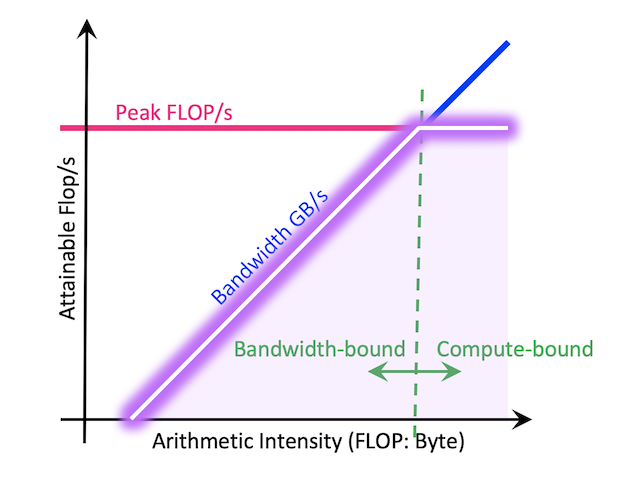

#### Question 2.1.1 (5 points)

Plot the roofline of matrix-matrix multiplication of the given dimensions. You can use the `plot_roofline` function we provide for you. You can assume all matrices are in `float32`.

<Axes: title={'center': 'Roofline Model - A6000'}, xlabel='Arithmetic Intensity', ylabel='Attainable Performance (TFLOPS)'>

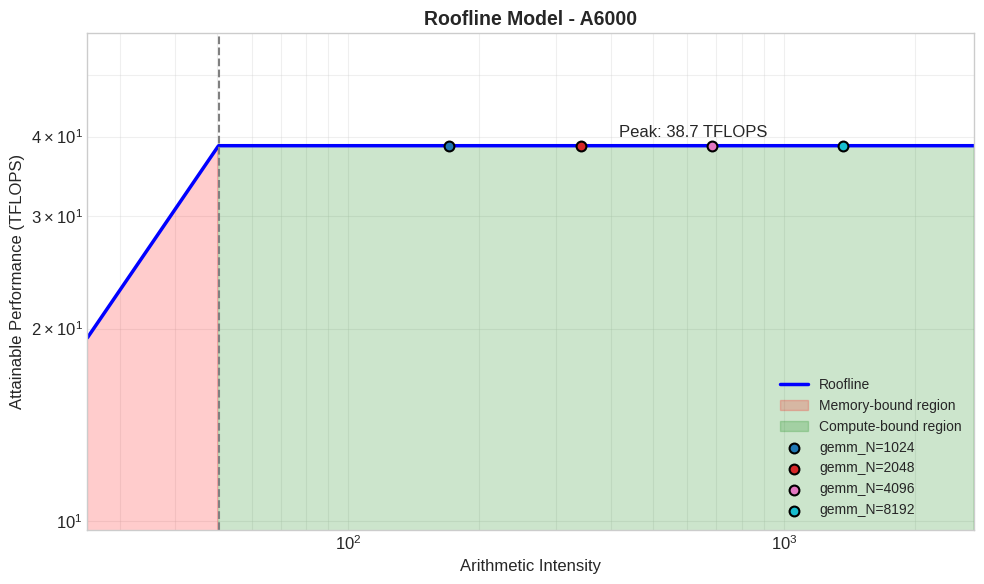

In [14]:
Ns = [1024, 2048, 4096, 8192]
gpu_name = "A6000"  # change to the device you are using
gpu_spec = GPU_SPECS[gpu_name]
peak_flops = gpu_spec["fp32_tflops"]
peak_bandwidth = gpu_spec["memory_bandwidth_tb_s"]

# YOUR CODE HERE
ai_to_plot = {}
for N in Ns:
    flops = 2 * N * N * N                    # 2N³ FLOPs
    io_bytes = 3 * N * N * 4                 # 3N² elements × 4 bytes (float32)
    ai_to_plot[f"gemm_N={N}"] = flops / io_bytes

plot_roofline(gpu_name, peak_flops, peak_bandwidth, ai_to_plot)
#raise NotImplementedError()


#### Question 2.1.2 (5 points)

How large does N need to be for the gemm to become compute bound on A6000? Provide your derivation. All tensors are in `float32`.

**Your Answer:**

#### Question 2.2 (5 points)

Now let's plot the roofline of gemv. The settings are the same as above. Describe your findings.

**Your Answer:**

> The GEMV roofline plot shows that matrix-vector multiplication is always memory-bound regardless of matrix size N. The arithmetic intensity for GEMV is approximately constant at ~0.5 FLOPs/Byte (since AI = 2N² / 4N² ≈ 0.5), which is far below the ridge point (~50). This means GEMV operations are limited by memory bandwidth, not compute capability. This is fundamentally different from GEMM where increasing N eventually makes the operation compute-bound.

<Axes: title={'center': 'Roofline Model - A6000'}, xlabel='Arithmetic Intensity', ylabel='Attainable Performance (TFLOPS)'>

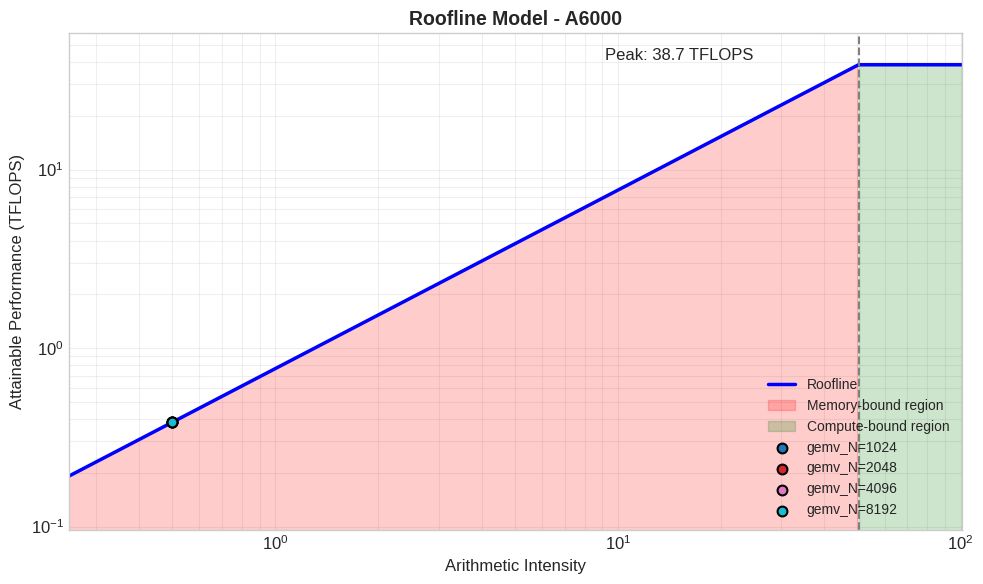

In [15]:
Ns = [1024, 2048, 4096, 8192]
gpu_name = "A6000"
gpu_spec = GPU_SPECS[gpu_name]
peak_flops = gpu_spec["fp32_tflops"]
peak_bandwidth = gpu_spec["memory_bandwidth_tb_s"]

# YOUR CODE HERE
ai_to_plot = {}
for N in Ns:
    flops = 2 * N * N                        # 2N² FLOPs
    io_bytes = (N * N + N + N) * 4           # (N² + 2N) elements × 4 bytes
    ai_to_plot[f"gemv_N={N}"] = flops / io_bytes

plot_roofline(gpu_name, peak_flops, peak_bandwidth, ai_to_plot)
# raise NotImplementedError()


# Part 3: Case Study - Gemma-3 Decoder Layer

In this section, we will walk you through [gemma-3-270m-it](https://huggingface.co/google/gemma-3-270m-it), a lightweight instruction-tuned language model, as a case study to enhance your profiling knowledge.

All components of the model's one decoder layer are shown below. These components are (in the order of forward execution)
- **Input LayerNorm**
- **Self-Attention Layer**
    - Query and Key Norm
    - Query, Key, and Value Projections
    - Rotary Embedding
    - Output Projection
- **Post Attention LayerNorm**
- **Pre MLP LayerNorm**
- **MLP**
    - Gate Projection
    - Up Projection
    - Activation
    - Down Projection
- **Post MLP LayerNorm**

You don't have to know all details. We will break it down later.

In [15]:
import math
import functools
import torch
import torch.nn as nn
from transformers.utils import TransformersKwargs
from transformers.utils.generic import maybe_autocast
from transformers.processing_utils import Unpack
from transformers.cache_utils import Cache
from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS
from transformers.models.gemma3.configuration_gemma3 import Gemma3TextConfig


class GELUTanh(nn.Module):

    def __init__(self, use_gelu_tanh_python: bool = False):
        super().__init__()
        self.act = functools.partial(nn.functional.gelu, approximate="tanh")

    def forward(self, input):
        return self.act(input)


def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


class Gemma3MLP(nn.Module):
    def __init__(self, config: Gemma3TextConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.act_fn = GELUTanh()

    def forward(self, x):
        with torch.profiler.record_function("gate_proj"):
            gate = self.gate_proj(x)
        with torch.profiler.record_function("up_proj"):
            up_x = self.up_proj(x)
        with torch.profiler.record_function("act_fn"):
            gate_up = self.act_fn(gate) * up_x
        with torch.profiler.record_function("down_proj"):
            down_proj = self.down_proj(gate_up)
        return down_proj


class Gemma3RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.zeros(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float())
        output = output * (1.0 + self.weight.float())
        return output.type_as(x)

    def extra_repr(self):
        return f"{tuple(self.weight.shape)}, eps={self.eps}"


class Gemma3Attention(nn.Module):

    def __init__(self, config: Gemma3TextConfig, layer_idx: int):
        super().__init__()
        self.layer_type = config.layer_types[layer_idx] if hasattr(config, "layer_types") else None
        self.config = config
        self.layer_idx = layer_idx
        self.head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        self.num_key_value_groups = config.num_attention_heads // config.num_key_value_heads
        self.scaling = config.query_pre_attn_scalar**-0.5
        self.attention_dropout = self.config.attention_dropout
        self.is_causal = True

        self.q_proj = nn.Linear(
            config.hidden_size, config.num_attention_heads * self.head_dim, bias=config.attention_bias
        )
        self.k_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.attention_bias
        )
        self.v_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.attention_bias
        )
        self.o_proj = nn.Linear(
            config.num_attention_heads * self.head_dim, config.hidden_size, bias=config.attention_bias
        )
        self.attn_logit_softcapping = None
        self.sliding_window = None
        self.is_sliding = False

        self.q_norm = Gemma3RMSNorm(dim=config.head_dim, eps=config.rms_norm_eps)
        self.k_norm = Gemma3RMSNorm(dim=config.head_dim, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: torch.Tensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        use_kv_cache: bool = True,
        past_key_values: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        prefill_hidden_states: Optional[torch.Tensor] = None,
        **kwargs: Unpack[TransformersKwargs],
    ) -> tuple[torch.Tensor, Optional[torch.Tensor], Optional[tuple[torch.Tensor]]]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        with torch.profiler.record_function("q_proj"):
            query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        query_states = self.q_norm(query_states)

        if use_kv_cache:
            with torch.profiler.record_function("k_proj"):
                key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
            with torch.profiler.record_function("v_proj"):
                value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)
            key_states = self.k_norm(key_states)
            cos, sin = position_embeddings
            query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

            assert past_key_values is not None, "past_key_values should not be None when use_kv_cache is True"
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_cache, value_cache = past_key_values.layers[self.layer_idx].keys, past_key_values.layers[self.layer_idx].values
            if key_cache is not None:
                key_states = torch.cat([key_cache, key_states], dim=2)
                value_states = torch.cat([value_cache, value_states], dim=2)
            else:
                past_key_values.layers[self.layer_idx].keys = key_states
                past_key_values.layers[self.layer_idx].values = value_states

        else:
            assert prefill_hidden_states is not None, "prefill_hidden_states should not be None when use_kv_cache is False"
            all_hidden_states = torch.cat([prefill_hidden_states, hidden_states], dim=1)
            full_shape = (*all_hidden_states.shape[:-1], -1, self.head_dim)
            key_states = self.k_proj(all_hidden_states).view(full_shape).transpose(1, 2)
            value_states = self.v_proj(all_hidden_states).view(full_shape).transpose(1, 2)
            key_states = self.k_norm(key_states)
            cos, sin = position_embeddings
            query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        # we will use flash attention by default
        attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]
        with torch.profiler.record_function("attn_op"):
            attn_output, _ = attention_interface(
                self,
                query_states,
                key_states,
                value_states,
                attention_mask,
                dropout=self.attention_dropout if self.training else 0.0,
                scaling=self.scaling,
                sliding_window=self.sliding_window,
                **kwargs,
            )

        attn_output = attn_output.reshape(*input_shape, -1).contiguous()
        attn_output = self.o_proj(attn_output)
        return attn_output


class Gemma3RotaryEmbedding(nn.Module):
    inv_freq: torch.Tensor

    def __init__(self, config, device=None, layer_type=None):
        super().__init__()
        self.max_seq_len_cached = config.max_position_embeddings
        self.original_max_seq_len = config.max_position_embeddings

        self.config = config
        self.rope_type = {}
        rope_params = self.config.rope_parameters[layer_type]
        self.rope_type[layer_type] = rope_params["rope_type"]
        rope_init_fn = self.compute_default_rope_parameters
        curr_inv_freq, curr_attention_scaling = rope_init_fn(self.config, device, layer_type=layer_type)
        self.register_buffer(f"{layer_type}_inv_freq", curr_inv_freq, persistent=False)
        setattr(self, f"{layer_type}_original_inv_freq", curr_inv_freq)
        setattr(self, f"{layer_type}_attention_scaling", curr_attention_scaling)

    @staticmethod
    def compute_default_rope_parameters(
        config: Optional[Gemma3TextConfig] = None,
        device: Optional["torch.device"] = None,
        seq_len: Optional[int] = None,
        layer_type: Optional[str] = None,
    ) -> tuple["torch.Tensor", float]:
        base = config.rope_parameters[layer_type]["rope_theta"]
        dim = getattr(config, "head_dim", None) or config.hidden_size // config.num_attention_heads

        attention_factor = 1.0
        inv_freq = 1.0 / (
            base ** (torch.arange(0, dim, 2, dtype=torch.int64).to(device=device, dtype=torch.float) / dim)
        )
        return inv_freq, attention_factor

    @torch.no_grad()
    def forward(self, x, position_ids, layer_type=None):
        inv_freq = getattr(self, f"{layer_type}_inv_freq")
        attention_scaling = getattr(self, f"{layer_type}_attention_scaling")

        inv_freq_expanded = inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1).to(x.device)
        position_ids_expanded = position_ids[:, None, :].float()

        device_type = x.device.type if isinstance(x.device.type, str) and x.device.type != "mps" else "cpu"
        with maybe_autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos() * attention_scaling
            sin = emb.sin() * attention_scaling

        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


class Gemma3DecoderLayer(nn.Module):
    def __init__(self, config: Gemma3TextConfig, layer_idx: int):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.layer_idx = layer_idx
        self.attention_type = "full_attention"
        self.self_attn = Gemma3Attention(config=config, layer_idx=layer_idx)
        self.mlp = Gemma3MLP(config)
        self.input_layernorm = Gemma3RMSNorm(self.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = Gemma3RMSNorm(self.hidden_size, eps=config.rms_norm_eps)
        self.pre_feedforward_layernorm = Gemma3RMSNorm(self.hidden_size, eps=config.rms_norm_eps)
        self.post_feedforward_layernorm = Gemma3RMSNorm(self.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: torch.Tensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs: Unpack[TransformersKwargs],
    ) -> tuple[torch.FloatTensor, Optional[tuple[torch.FloatTensor, torch.FloatTensor]]]:
        residual = hidden_states

        with torch.profiler.record_function("input_norm"):
            hidden_states = self.input_layernorm(hidden_states)

        with torch.profiler.record_function("self_attn"):
            hidden_states = self.self_attn(
                hidden_states=hidden_states,
                position_embeddings=position_embeddings,
                attention_mask=attention_mask,
                position_ids=position_ids,
                past_key_values=past_key_values,
                cache_position=cache_position,
                **kwargs,
            )

        with torch.profiler.record_function("post_attn_norm"):
            hidden_states = self.post_attention_layernorm(hidden_states)
        with torch.profiler.record_function("res"):
            hidden_states = residual + hidden_states

        residual = hidden_states

        with torch.profiler.record_function("pre_ffn_norm"):
            hidden_states = self.pre_feedforward_layernorm(hidden_states)
        with torch.profiler.record_function("mlp"):
            hidden_states = self.mlp(hidden_states)
        with torch.profiler.record_function("post_ffn_norm"):
            hidden_states = self.post_feedforward_layernorm(hidden_states)
        with torch.profiler.record_function("res"):
            hidden_states = residual + hidden_states

        return hidden_states

## Part 3.1: MAC & FLOPs

In [16]:
class GELUTanh(nn.Module):
    def __init__(self, use_gelu_tanh_python: bool = False):
        super().__init__()
        self.act = functools.partial(nn.functional.gelu, approximate="tanh")

    def forward(self, input):
        return self.act(input)

class Gemma3MLP(nn.Module):
    def __init__(self, config: Gemma3TextConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.act_fn = GELUTanh()

    def forward(self, x):
        gate = self.gate_proj(x)
        up_x = self.up_proj(x)
        gate_up = self.act_fn(gate) * up_x
        down_proj = self.down_proj(gate_up)
        return down_proj

In this section, we will walk through the MAC & FLOPs computation of the MLP in the decoder layer. The MLP takes in a tensor `x` of shape `(B, L, D)` and outputs a tensor of the same shape. Based on the code below, we can break down the operations as follows:
- `gate_proj`: This is a linear layer with weight $W \in \mathbb{R}^{I \times D}$, so
    - MAC = $B \times L \times D \times I$
    - FLOPs = $2 \times B \times L \times D \times I$
- `up_proj`: This is a linear layer with weight $W \in \mathbb{R}^{I \times D}$, so
    - MAC = $B \times L \times D \times I$
    - FLOPs = $2 \times B \times L \times D \times I$
- `act_fn`: The input is a tensor with shape `(B, L, I)`. Each element goes through 8 operations (6 mul, 2 add, and note that we consider non-fused GeLU here which will be discussed later). So, the
    - MAC is not measurable (numerically 0) because a GeLU unit can't be simplified into a single clock-cycle MAC.
    - FLOPs = $8 \times B \times L \times I$
- `gate_up`: This is an element-wise multiplication of two matrices of shape `(B, L, I)`, so
    - MAC is also not applicable in this case (numerically 0) since there's no "add"
    - FLOPs = $B \times L \times I$
- `down_proj`: This is a linear layer with weight $W \in \mathbb{R}^{D \times I}$, so
    - MAC = $B \times L \times I \times D$
    - FLOPs = $2 \times B \times L \times I \times D$

In [17]:
def calc_mlp_mac(B, L, D, I):
    """
    Args:
        B (int): Batch size.
        L (int): Sequence length.
        D (int): Hidden dimension.
        I (int): Intermediate (FFN) dimension.
    Returns:
        int: Total MACs for the MLP block (gate, up, down projections).
    """
    gate_proj = B * L * D * I
    up_proj = B * L * D * I
    act_fn = 0
    gate_up = 0
    down_proj = B * L * I * D
    return gate_proj + up_proj + act_fn + gate_up + down_proj

def calc_mlp_flops(B, L, D, I):
    """
    Args:
        B (int): Batch size.
        L (int): Sequence length.
        D (int): Hidden dimension.
        I (int): Intermediate (FFN) dimension.
    Returns:
        int: Total floating-point operations for the full MLP path.
    """
    gate_proj = 2 * B * L * D * I
    up_proj = 2 * B * L * D * I
    act_fn = 8 * B * L * I
    gate_up = B * L * I
    down_proj = 2 * B * L * I * D
    return gate_proj + up_proj + act_fn + gate_up + down_proj

#### Question 3.1 (10 points)

(1) Please implement the standard scale-dot-product attention from scratch. You can assume all tensors are in `float32`. (2) Then, calculate its MAC. The shape of q is `(B, H, L_q, D)` and the shape of k,v is `(B, H, L_kv, D)`.

In [18]:
def scaled_dot_product_attention(q, k, v, attn_mask=None):
    """
    Args:
        q (torch.Tensor): Query tensor of shape (B, H, L_q, D_h).
        k (torch.Tensor): Key tensor of shape (B, H, L_kv, D_h).
        v (torch.Tensor): Value tensor of shape (B, H, L_kv, D_h).
        attn_mask (torch.Tensor, optional): Attention mask of shape (B, H, L_q, L_kv).
    Returns:
        torch.Tensor: Attention output of shape (B, H, L_q, D_h).
    """
    # YOUR CODE HERE
    B, H, L_q, D_h = q.shape
    B, H, L_kv, D_h = k.shape
    B, H, L_kv, D_h = v.shape
    if attn_mask is not None:
        B, H, L_q, L_kv = attn_mask.shape

    scores = torch.matmul(q, k.transpose(-2,-1) / math.sqrt(D_h))
    if attn_mask is not None:
        scores = scores + attn_mask
    
    attn_weights = torch.softmax(scores, dim=-1)

    output = torch.matmul(attn_weights, v)
    return output

def calc_attn_mac(B, H, L_q, L_kv, D_h):
    """
    Args:
        B (int): Batch size.
        H (int): Number of attention heads.
        L_q (int): Query sequence length.
        L_kv (int): Key/value sequence length.
        D_h (int): Per-head hidden size.
    Returns:
        int: Total MACs for scaled dot-product attention.
    """
    # calculate the MAC of q @ k.T
    # YOUR CODE HERE
    attn_qk = B * H * L_q * L_kv * D_h

    # MAC is not applicable to softmax, so we ignore it
    softmax = 0

    # calculate the MAC of attn @ v
    # YOUR CODE HERE
    attn_v = B * H * L_q * L_kv * D_h
    
    return attn_qk + softmax + attn_v


In [20]:
# Public Testcase for SDPA
q = torch.randn(1, 4, 1024, 128, dtype=torch.float32, device=device)
k = torch.randn(1, 4, 1024, 128, dtype=torch.float32, device=device)
v = torch.randn(1, 4, 1024, 128, dtype=torch.float32, device=device)
out = scaled_dot_product_attention(q, k, v)
expected = torch.nn.functional.scaled_dot_product_attention(q, k, v)
torch.testing.assert_close(out, expected)

# Public Testcase for MAC
B, H, L_q, L_kv, D_h = 1, 4, 173, 256, 128
assert calc_attn_mac(B, H, L_q, L_kv, D_h) == 45350912


#### Bonus 3.1 (5 points)

Can you compute the MAC of the whole `GemmaAttention` module?

**Your Answer (Optional):**

> The total MAC for the GemmaAttention module is:
>
> Total MAC = q_proj + k_proj + v_proj + Q@K^T + Attn@V + o_proj
>
> Where:
> - q_proj MAC = B × S_q × H × (n_h × d)
> - k_proj MAC = B × S_kv × H × (n_kv × d)
> - v_proj MAC = B × S_kv × H × (n_kv × d)
> - Q@K^T MAC = B × n_h × S_q × S_kv × d
> - Attn@V MAC = B × n_h × S_q × S_kv × d
> - o_proj MAC = B × S_q × (n_h × d) × H

In [19]:
def calc_attn_module_mac(batch_size, query_len, kv_len, gemma_config):
    """
    Args:
        batch_size (int): Batch size.
        query_len (int): Query sequence length.
        kv_len (int): Key/value sequence length.
        gemma_config (GemmaConfig): Gemma configuration.
    Returns:
        int: Total MACs for the whole `GemmaAttention` module.
    """

    B = batch_size
    S_q = query_len
    S_kv = kv_len
    H = gemma_config.hidden_size
    n_h = gemma_config.num_attention_heads
    n_kv = gemma_config.num_key_value_heads
    d = gemma_config.head_dim

    # YOUR CODE HERE
    q_proj_mac = B * S_q * H * (n_h * d)
    k_proj_mac = B * S_kv * H * (n_kv * d)
    v_proj_mac = B * S_kv * H * (n_kv * d)

    attn_mac = B * n_h * S_q * S_kv * d
    attn_v_mac = B * n_h * S_q * S_kv * d

    o_proj_mac = B * S_q * (n_h * d) * H

    total_mac = q_proj_mac + k_proj_mac + v_proj_mac + attn_mac + attn_v_mac + o_proj_mac
    return total_mac


## Part 3.2: I/O

Next, let's practice the I/O calculation. Again, let's first analyze the MLP. Do note that we assume model weights are already loaded and exclude I/O of model weight loading from our computation for simplicity. We again break down the layer as follows:
- `gate_proj`: Read tensors of shapes `(B, L, D)` and `(I, D)`, and write a tensor of shape `(B, L, I)`. So the I/O is $2 \times (B \times L \times D + D \times I + B \times L \times I)$
- `up_x`: Read tensors of shapes `(B, L, D)` and `(I, D)`, and write a tensor of shape `(B, L, I)`. So the I/O is $2 \times (B \times L \times D + D \times I + B \times L \times I)$
- `act_fn`: Read a tensor of shape `(B, L, I)` and write a tensor of the same shape. So the I/O is $2 \times 2 \times B \times L \times I$
- `gate_up`: Read two tensors of shape `(B, L, I)` and write a tensor of `(B, L, I)`. So the I/O is $2 \times 3 \times B \times L \times I$
- `down_proj`: Read tensors of shapes `(B, L, I)` and `(D, I)`, and write a tensor of shape `(B, L, D)`. So the I/O is $2 \times (B \times L \times I + D \times I + B \times L \times D)$

In [20]:
def calc_mlp_io(B, L, D, I):
    """
    Args:
        B (int): Batch size.
        L (int): Sequence length.
        D (int): Hidden dimension.
        I (int): Intermediate (FFN) dimension.
    Returns:
        int: Total bytes read/written for the MLP block assuming fp16/bf16 (2 bytes per element) doubled for read/write.
    """
    gate_proj = 2 * (B * L * D + D * I + B * L * I)
    up_x = 2 * (B * L * D + D * I + B * L * I)
    act_fn = 2 * 2 * B * L * I
    gate_up = 2 * 3 * B * L * I
    down_proj = 2 * (B * L * I + D * I + B * L * D)
    return gate_proj + up_x + act_fn + gate_up + down_proj

#### Question 3.2 (5 points)

Please calculate the I/O of the standard attention you just implemented. The shape of q is `(B, H, L_q, D)` and the shape of k,v is `(B, H, L_kv, D)`. All tensors are in `float32`

In [21]:
def calc_attn_io(B, H, L_q, L_kv, D_h):
    """
    Args:
        B (int): Batch size.
        H (int): Number of attention heads.
        L_q (int): Query sequence length.
        L_kv (int): Key/value sequence length.
        D_h (int): Per-head hidden size.
    Returns:
        int: Total bytes moved (bf16, read+write) for standard attention.
    """
    # Hint: for softmax, you can use the following formula:
    # I/O(softmax) = 5 * (B * H * L_q * L_kv) * 4(fp32)

    bytes_per_elem = 4
    # YOUR CODE HERE
    # read key, read query, write score
    qk_io = (B * H * L_kv * D_h + B * H * L_q * D_h + B * H * L_q * L_kv) * bytes_per_elem
    # from the hint
    softmax_io = 5 * (B * H * L_q * L_kv) * bytes_per_elem
    # read attn, read values, write output
    attn_v_io = (B * H * L_q * L_kv + B * H * L_kv * D_h + B * H * L_q * D_h) * bytes_per_elem

    total_io = qk_io + softmax_io + attn_v_io 
    return total_io
    
    # raise NotImplementedError()


#### Bonus 3.2 (5 points)

Can you compute the I/O of the whole `GemmaAttention` module? You only need to consider the 'prefill' stage and all tensors are in `bfloat16`. For simplicity, let's ignore weights loading and only focus on the forward pass.

**Your Answer (Optional):**

> The total I/O for the GemmaAttention module during prefill (in bfloat16, ignoring weight loading) is computed as follows:
>
> Variables:
> - B = batch_size
> - S_q = query_len, S_kv = kv_len
> - H = hidden_size
> - n_h = num_attention_heads
> - n_kv = num_key_value_heads
> - d = head_dim
> - bytes_per_elem = 2 (bfloat16)
>
> I/O for each operation:
>
> | Operation | Read | Write | I/O (elements) |
> |-----------|------|-------|----------------|
> | q_proj | Input (B, S_q, H) | Q (B, S_q, n_h×d) | B×S_q×H + B×S_q×n_h×d |
> | k_proj | Input (B, S_kv, H) | K (B, S_kv, n_kv×d) | B×S_kv×H + B×S_kv×n_kv×d |
> | v_proj | Input (B, S_kv, H) | V (B, S_kv, n_kv×d) | B×S_kv×H + B×S_kv×n_kv×d |
> | Q @ K^T | Q, K | Scores (B, n_h, S_q, S_kv) | B×n_h×S_q×d + B×n_h×S_kv×d + B×n_h×S_q×S_kv |
> | Softmax | ~5 passes | over attention matrix | 5 × B×n_h×S_q×S_kv |
> | Attn @ V | Attn, V | Output (B, n_h, S_q, d) | B×n_h×S_q×S_kv + B×n_h×S_kv×d + B×n_h×S_q×d |
> | o_proj | Input (B, S_q, n_h×d) | Output (B, S_q, H) | B×S_q×n_h×d + B×S_q×H |
>
> Total I/O (bytes) = (sum of all elements) × 2
>
> The dominant I/O cost comes from the attention matrix operations (Q@K^T and softmax), which scale as O(S_q × S_kv) — this quadratic dependence on sequence length is why standard attention becomes memory-bound for long sequences and why Flash Attention (which avoids materializing the full attention matrix) provides significant speedups.

In [22]:
def calc_attn_module_io(batch_size, query_len, kv_len, gemma_config):
    """
    Args:
        batch_size (int): Batch size.
        query_len (int): Query sequence length.
        kv_len (int): Key/value sequence length.
        gemma_config (GemmaConfig): Gemma configuration.
    Returns:
        int: Total bytes moved (bf16, read+write) for the whole `GemmaAttention` module.
    """

    B = batch_size
    S_q = query_len
    S_kv = kv_len
    H = gemma_config.hidden_size
    n_h = gemma_config.num_attention_heads
    n_kv = gemma_config.num_key_value_heads
    d = gemma_config.head_dim
    bytes_per_elem = 2

    # YOUR CODE HERE
    # q_proj - read input from (B, S_q, H), write q (B, S_q, n_h * d)
    q_proj_io = (B * S_q * H + B * S_q * n_h * d) * bytes_per_elem
    # k_proj - read input (B, S_kv, H), write V (B, S_kv, n_kv * d)
    k_proj_io = (B * S_q * H + B * S_q * n_h * d) * bytes_per_elem
    # qk_io - read q (B, S_q, n_h * d) and k (B, S_kv, n_h * d), write score (B, n_h, S_q, S_kv)
    qk_io = (B * n_h * S_q * S_kv + B * n_h * S_q * d + B * n_h * S_kv * d) * bytes_per_elem
    # softmax - approx. 5 passes over attention matrix
    softmax_io = 5 * (B * n_h * S_q * S_kv) * bytes_per_elem
    # attn_score @ V - read attn_score (B, n_h, S_q, S_kv), read V (B, n_h, S_kv, d), write scores (B, n_h, S_q, d)
    attn_v_io = (B * n_h * S_q * S_kv + B * n_h * S_kv * d + B * n_h * S_q * d) * bytes_per_elem
    # o_proj - read input (B, n_h, S_q, d), write output (B, S_q, H)
    o_proj_io = (B * n_h * S_q * d + B * n_h * S_q * H ) * bytes_per_elem

    total_io = q_proj_io + k_proj_io + qk_io + softmax_io + attn_v_io + o_proj_io
    return total_io


## Part 3.3: Latency of Prefill and Decode

The inference process of current LLMs can be divided into two stages:
- Prefill stage processes the entire input prompt and stores the KV cache (a [blog](https://huggingface.co/blog/not-lain/kv-caching) in case you are not familiar with KV cache)
- Decode stage generates tokens one-by-one autoregressively using KV cache

We provide the code for measuring latencies of prefill, decode without kv cache, and decode with kv cache in the following cells. You can see how much speedup the kv cache bring to the inference.

**Please run this part on A100/A6000. A10 doesn't have enough memory for the default configuration. You can feel free to try smaller inputs, but it's likely you don't see a clear improvements. There are no questions in this section, so you can skip it if you are using A10 already**

In [25]:
batch_size = 8
seq_len = 4096
hidden_size = GEMMA3_PESUDO_CONFIG.hidden_size
num_layers = GEMMA3_PESUDO_CONFIG.num_hidden_layers
layer = Gemma3DecoderLayer(GEMMA3_PESUDO_CONFIG, 5).to(device="cuda", dtype=torch.bfloat16)
rotary_emb = Gemma3RotaryEmbedding(GEMMA3_PESUDO_CONFIG, layer_type="full_attention")

In [26]:
# Prefill (after prefilling, kv cache will be stored in past_key_values)
prefill_input, prefill_position_ids = create_prefill_inputs(batch_size, seq_len, hidden_size, dtype=torch.bfloat16, device="cuda")
prefill_position_embeddings = get_position_embeddings(prefill_input, prefill_position_ids, rotary_emb, layer_type="full_attention")
past_key_values = initialize_kv_cache(config=GEMMA3_PESUDO_CONFIG, max_cache_len=seq_len)
latency(
    multi_layer_prefill_forward,
    num_layers,
    layer=layer,
    hidden_states=prefill_input,
    position_ids=prefill_position_ids,
    position_embeddings=prefill_position_embeddings,
    past_key_values=past_key_values
)

1.5514112548828125

In [27]:
# Decode without KV cache
decode_input, decode_position_ids, prefill_hidden_states = create_decode_inputs_without_cache(batch_size, seq_len, hidden_size, dtype=torch.bfloat16, device="cuda")
decode_position_embeddings = get_position_embeddings(decode_input, decode_position_ids, rotary_emb, layer_type="full_attention")
latency(
    multi_layer_decode_forward,
    num_layers,
    layer=layer,
    hidden_states=decode_input,
    position_ids=decode_position_ids,
    position_embeddings=decode_position_embeddings,
    past_key_values=None,
    cache_positions=None,
    use_kv_cache=False,
    prefill_hidden_states=prefill_hidden_states
)

0.2511042175292969

In [28]:
# Decode with KV cache
decode_input, decode_position_ids, decode_cache_positions = create_decode_inputs_with_cache(batch_size, seq_len, hidden_size, dtype=torch.bfloat16, device="cuda")
decode_position_embeddings = get_position_embeddings(decode_input, decode_position_ids, rotary_emb, layer_type="full_attention")
latency(
    multi_layer_decode_forward,
    num_layers,
    layer=layer,
    hidden_states=decode_input,
    position_ids=decode_position_ids,
    position_embeddings=decode_position_embeddings,
    past_key_values=past_key_values,
    cache_positions=decode_cache_positions,
    use_kv_cache=True,
    prefill_hidden_states=None
)

0.05053927612304687

In [29]:
del prefill_input, prefill_position_ids, prefill_position_embeddings, past_key_values, decode_input, decode_position_ids, decode_position_embeddings, decode_cache_positions, prefill_hidden_states
torch.cuda.empty_cache()

## Part 3.4: Roofline

Next, we will plot the roofline using the FLOP and I/O analysis above. Let's first see how the prefill performs.

<Axes: title={'center': 'Roofline Model - A6000'}, xlabel='Arithmetic Intensity', ylabel='Attainable Performance (TFLOPS)'>

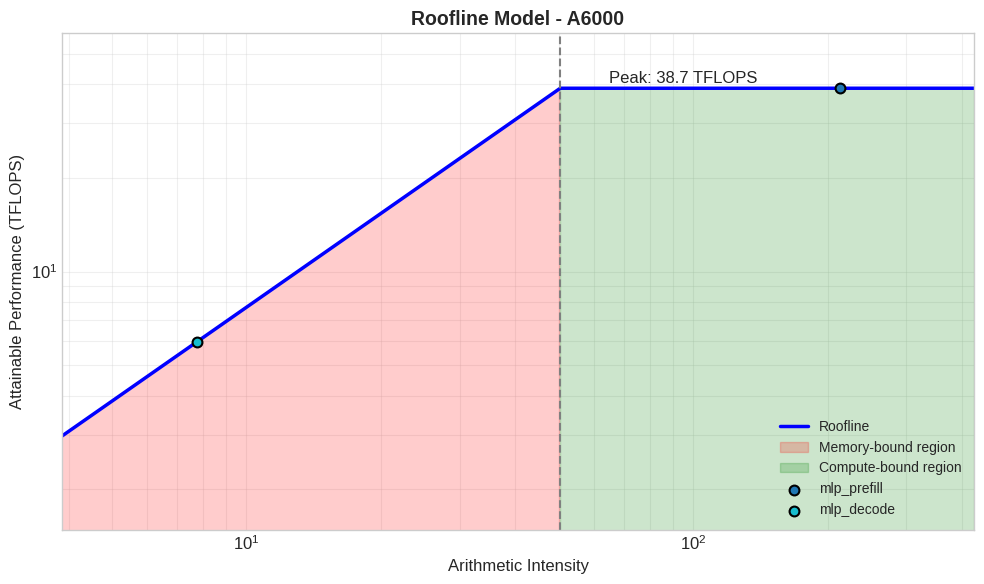

In [30]:
B = 8
D = GEMMA3_270M_CONFIG.hidden_size
D_h = GEMMA3_270M_CONFIG.head_dim
I = GEMMA3_270M_CONFIG.intermediate_size
H = GEMMA3_270M_CONFIG.num_attention_heads
L_q = 2048
L_kv = 2048

mlp_prefill_flops = calc_mlp_flops(B, L_q, D, I)
mlp_prefill_io = calc_mlp_io(B, L_q, D, I)
mlp_decode_flops = calc_mlp_flops(B, 1, D, I)
mlp_decode_io = calc_mlp_io(B, 1, D, I)

ai_to_plot = {
    'mlp_prefill': mlp_prefill_flops / mlp_prefill_io,
    'mlp_decode': mlp_decode_flops / mlp_decode_io,
}

plot_roofline(
    gpu_name,
    peak_flops,
    peak_bandwidth,
    ai_to_plot
)

You can clearly see from the figure above that the bottleneck of MLP is very different on the two stages. During prefilling, the layer is compute-bound. During decoding, it becomes memory-bound. In fact, this is not restricted to MLP. It's an important feature of modern LLM whose inference can be divided into prefill and decode stages. The prefilling is usually compute-bound and decoding is usually memory bound.

#### Question 3.4.1 (5 points)

Explain in words why the performance bottleneck of the MLP layer is different for prefilling and decoding. (Hint: think about the shapes of the query for prefilling and decoding, and how they are related to gemm and gemv)

**Your Answer:**

> The performance bottleneck differs because of the shape of the input:
>
> - Prefill (L_q = 2048): Processes the entire prompt at once. The operation is GEMM (matrix × matrix) with high arithmetic intensity. Weight I/O is amortized over many tokens, making it compute-bound.
>
> - Decode (L_q = 1): Generates one token at a time. The operation becomes GEMV (matrix × vector) with low arithmetic intensity (~1 FLOP/Byte). The same weights must be loaded from memory for just one token's computation, making it memory-bound.
>
> The key insight is that GEMM operations scale better with input size (N/6 arithmetic intensity), while GEMV operations have nearly constant, low arithmetic intensity (~0.5).

#### Question 3.4.2 (5 points)

Vary the batch size (B) of the decoding stage and plot them on the same roofline. Describe your findings.

**Your Answer:**

B=1:  AI=0.9977  (memory-bound)

B=4:  AI=3.9361  (memory-bound)

B=16: AI=14.9258 (memory-bound)

B=64: AI=49.4254 (approaching compute-bound)

B=1: FLOPs=7,882,752, I/O=7,900,928, AI=0.9977
B=4: FLOPs=31,531,008, I/O=8,010,752, AI=3.9361
B=16: FLOPs=126,124,032, I/O=8,450,048, AI=14.9258
B=64: FLOPs=504,496,128, I/O=10,207,232, AI=49.4254

ai_to_plot: {'mlp_decode_B=1': 0.9976995107410167, 'mlp_decode_B=4': 3.9360859005496613, 'mlp_decode_B=16': 14.925836160930684, 'mlp_decode_B=64': 49.42536115569823}


<Axes: title={'center': 'Roofline Model - A6000'}, xlabel='Arithmetic Intensity', ylabel='Attainable Performance (TFLOPS)'>

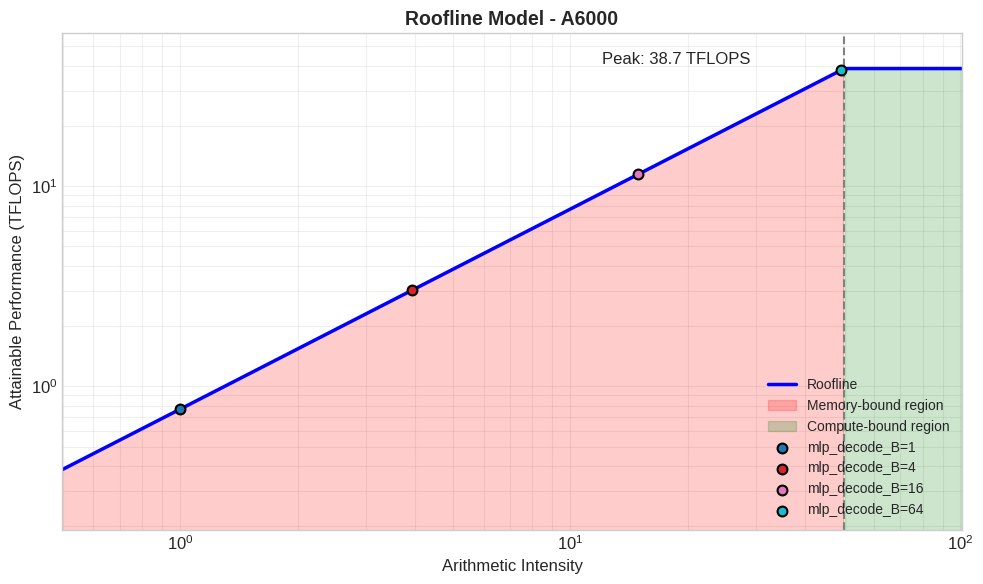

In [32]:
Bs = [1, 4, 16, 64]
D = GEMMA3_270M_CONFIG.hidden_size
D_h = GEMMA3_270M_CONFIG.head_dim
I = GEMMA3_270M_CONFIG.intermediate_size
H = GEMMA3_270M_CONFIG.num_attention_heads
L_q = 1

# YOUR CODE HERE
ai_to_plot = {}
for B in Bs:
    mlp_flops = calc_mlp_flops(B, L_q, D, I)
    mlp_io = calc_mlp_io(B, L_q, D, I)
    ai = mlp_flops / mlp_io
    ai_to_plot[f"mlp_decode_B={B}"] = ai
    print(f"B={B}: FLOPs={mlp_flops:,}, I/O={mlp_io:,}, AI={ai:.4f}")

print("\nai_to_plot:", ai_to_plot)
plot_roofline(gpu_name, peak_flops, peak_bandwidth, ai_to_plot)
# raise NotImplementedError()


#### Question 3.4.3 (5 points)

Vary the prefill length (L_q) of the prefilling and plot them on the same roofline. Describe your findings.

**Your Answer:**

> As prefill length increases, the MLP layer becomes increasingly compute-bound:
> - Shorter sequences (L=64): Lower arithmetic intensity, closer to memory-bound compared to longer sequence sizes
> - Longer sequences (L=4096): Higher arithmetic intensity, firmly compute-bound
>
> This occurs because FLOPs scale with sequence length, while weight I/O remains constant. The fixed cost of loading weights gets amortized over more computation as sequence length grows. This explains why prefill is compute-bound for typical prompt lengths, while decode (L=1) is always memory-bound.

<Axes: title={'center': 'Roofline Model - A6000'}, xlabel='Arithmetic Intensity', ylabel='Attainable Performance (TFLOPS)'>

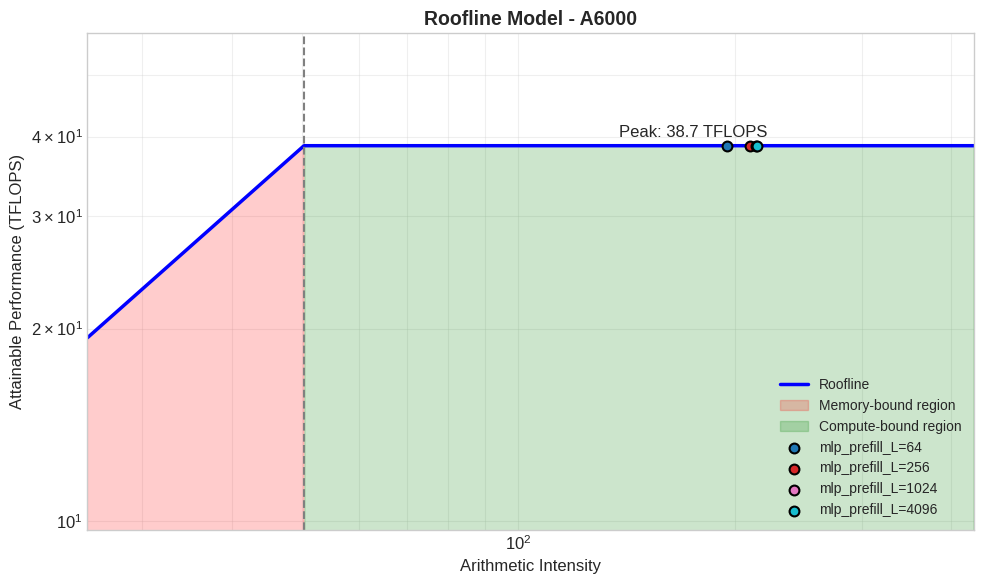

In [33]:
B = 32
D = GEMMA3_270M_CONFIG.hidden_size
D_h = GEMMA3_270M_CONFIG.head_dim
I = GEMMA3_270M_CONFIG.intermediate_size
H = GEMMA3_270M_CONFIG.num_attention_heads
Ls = [64, 256, 1024, 4096]

# YOUR CODE HERE
ai_to_plot = {}
for L in Ls:
    mlp_flops = calc_mlp_flops(B,L,D,I)
    mlp_io = calc_mlp_io(B,L,D,I)
    ai_to_plot[f"mlp_prefill_L={L}"] = mlp_flops/mlp_io

plot_roofline(gpu_name, peak_flops, peak_bandwidth, ai_to_plot)
# raise NotImplementedError()


# Part 4: Profiling with PyTorch Profiler

PyTorch Profiler is a built-in performance analysis tool that helps you understand where time and memory are spent in your models. It captures detailed metrics including CPU and CUDA kernel execution times, memory allocations, and call stacks.

## 4.1 Basic Profiling

Let's profile the matmul function using the Pytorch profiler

In [ ]:
from torch.profiler import profile, ProfilerActivity

A = torch.randn(128, 128, dtype=torch.bfloat16, device=device)
B = torch.randn(128, 128, dtype=torch.bfloat16, device=device)
with profile(schedule=default_schedule) as prof:
    for _ in range(10):
        y = torch.matmul(A, B)
        prof.step()
    torch.cuda.synchronize()

print(prof.key_averages().table(sort_by="cuda_time_total"))

You can see what CUDA kernels are actually being called. Name of CUDA kernel tells us something about the implementation. For example, nvjet_tst_64x8_64x16_2x4_v_bz_NNT refers to the actual kernel being used for matmul operation.

## 4.2 Profiling MLP

Next, let's profile something more complex. We again use our MLP layer for profiling.

In [ ]:
batch_size = 4
seq_len = 1024
hidden_size = GEMMA3_270M_CONFIG.hidden_size
x = torch.randn(batch_size, seq_len, hidden_size, dtype=torch.bfloat16, device=device)
mlp = Gemma3MLP(GEMMA3_270M_CONFIG).to(device=device, dtype=torch.bfloat16)

# profile
with profile(schedule=default_schedule) as prof:
    for _ in range(10):
        _ = mlp(x)
        prof.step()
    torch.cuda.synchronize()

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

You can see that there are a lot more kernels being invoked this time. In fact, we can visualize the operation timeline in a nicer way. First, save the trace file of the profiler by `prof.export_chrome_trace("trace.json")`. Then, go to (copy paste https://ui.perfetto.dev/ in browser if unable to open the link) and upload the file. You will then see the following diagram.

In [ ]:
prof.export_chrome_trace("trace.json")

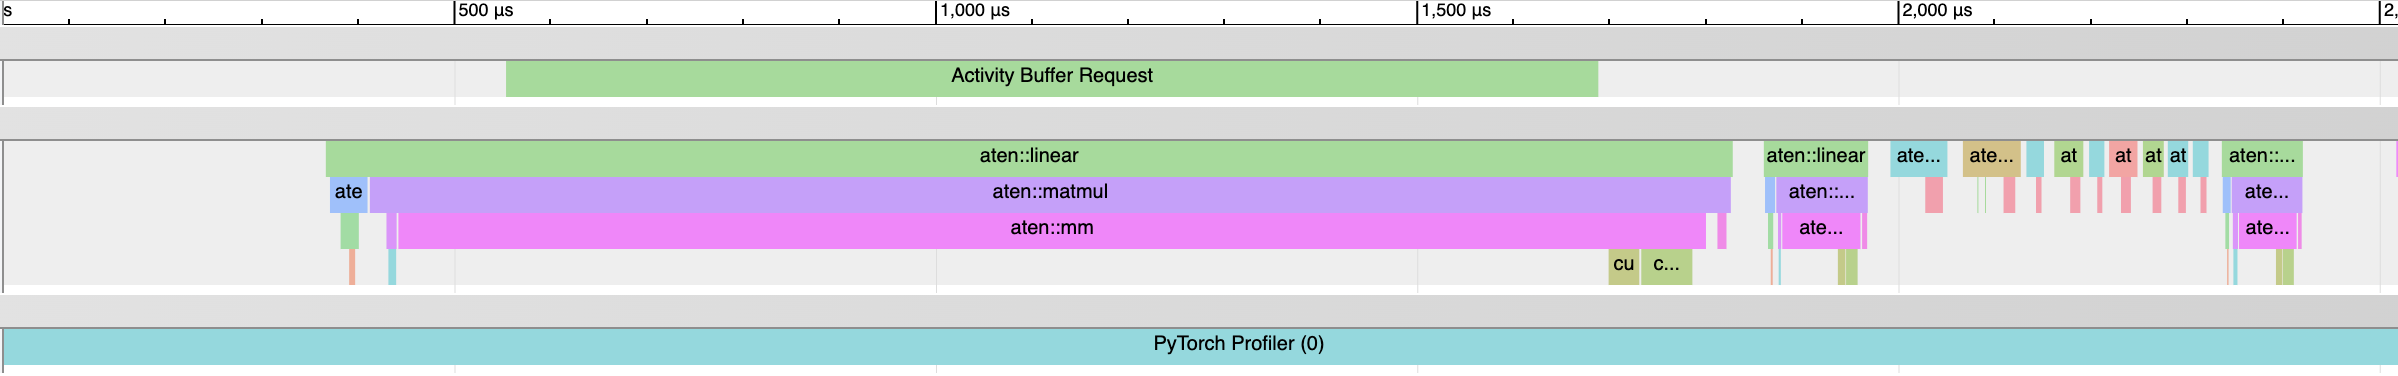

#### Bonus 4.2 (5 points)

Can you profile the decoding stage of the full decoder layer and show the timeline visualization?

![image](profiling2.png)

In [47]:
# YOUR CODE HERE
batch_size = 4
seq_len = 1024
hidden_size = GEMMA3_270M_CONFIG.hidden_size

layer = Gemma3DecoderLayer(GEMMA3_270M_CONFIG, 0).to(device="cuda", dtype=torch.bfloat16)
rotary_emb = Gemma3RotaryEmbedding(GEMMA3_270M_CONFIG, layer_type="full_attention")

#prefill to populate KV cache
prefill_input, prefill_position_ids = create_prefill_inputs(batch_size, seq_len, hidden_size, dtype=torch.bfloat16, device="cuda")

prefill_position_embeddings = get_position_embeddings(prefill_input, prefill_position_ids, rotary_emb, layer_type = "full_attention")

past_key_values = initialize_kv_cache(config=GEMMA3_270M_CONFIG, max_cache_len=seq_len + 100)

#prefill to fill the cache
with torch.inference_mode():
    _ = prefill_forward(layer, prefill_input, prefill_position_ids, prefill_position_embeddings, past_key_values)


decode_input, decode_position_ids, decode_cache_positions = create_decode_inputs_with_cache(batch_size, seq_len, hidden_size, dtype=torch.bfloat16, device="cuda")

decode_position_embeddings = get_position_embeddings(decode_input, decode_position_ids, rotary_emb, layer_type = "full_attention")

#profile with decode stage
with profile(
    activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA],
    schedule = default_schedule,
    on_trace_ready = torch.profiler.tensorboard_trace_handler(f'./decode_profile'),
    record_shapes = True,
    with_stack=True
) as prof:
    for _ in range(10):
        with torch.inference_mode():
            _ = decode_forward(
                layer, 
                decode_input, 
                decode_position_ids,
                decode_position_embeddings,
                True,                    # use_kv_cache
                past_key_values,         # past_key_values
                decode_cache_positions,  # cache_positions
                None                     # prefill_hidden_states (None when using KV cache)
            )
        prof.step()
    torch.cuda.synchronize()

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))    
# raise NotImplementedError()

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              self_attn         0.00%       0.000us         0.00%       0.000us       0.000us       6.487ms       458.25%       6.487ms       1.081ms             6  
                                          post_ffn_norm         0.00%       0.000us         0.00%       0.000us       0.000us       1.098ms        77.55%       1.098ms     182.971us             6  
         

In [ ]:
prof.export_chrome_trace("trace_gemma3_decode.json")

## 4.3 Kernel Fusion

As you can see from the profiling results, one simple operation could lead to a number of kernel launches. Each kernel launch takes time, thus too many launches result in overhead. This motivates us to fuse many kernels into one "large" kernel. Another benefit of kernel fusion is to reduce I/O overhead. You can read a very nice [blog post](https://horace.io/brrr_intro.html) by Horace He. We have extracted the main idea below for your reference.

We can model the relationship between our memory and compute as factory(compute) and warehouse(memory)

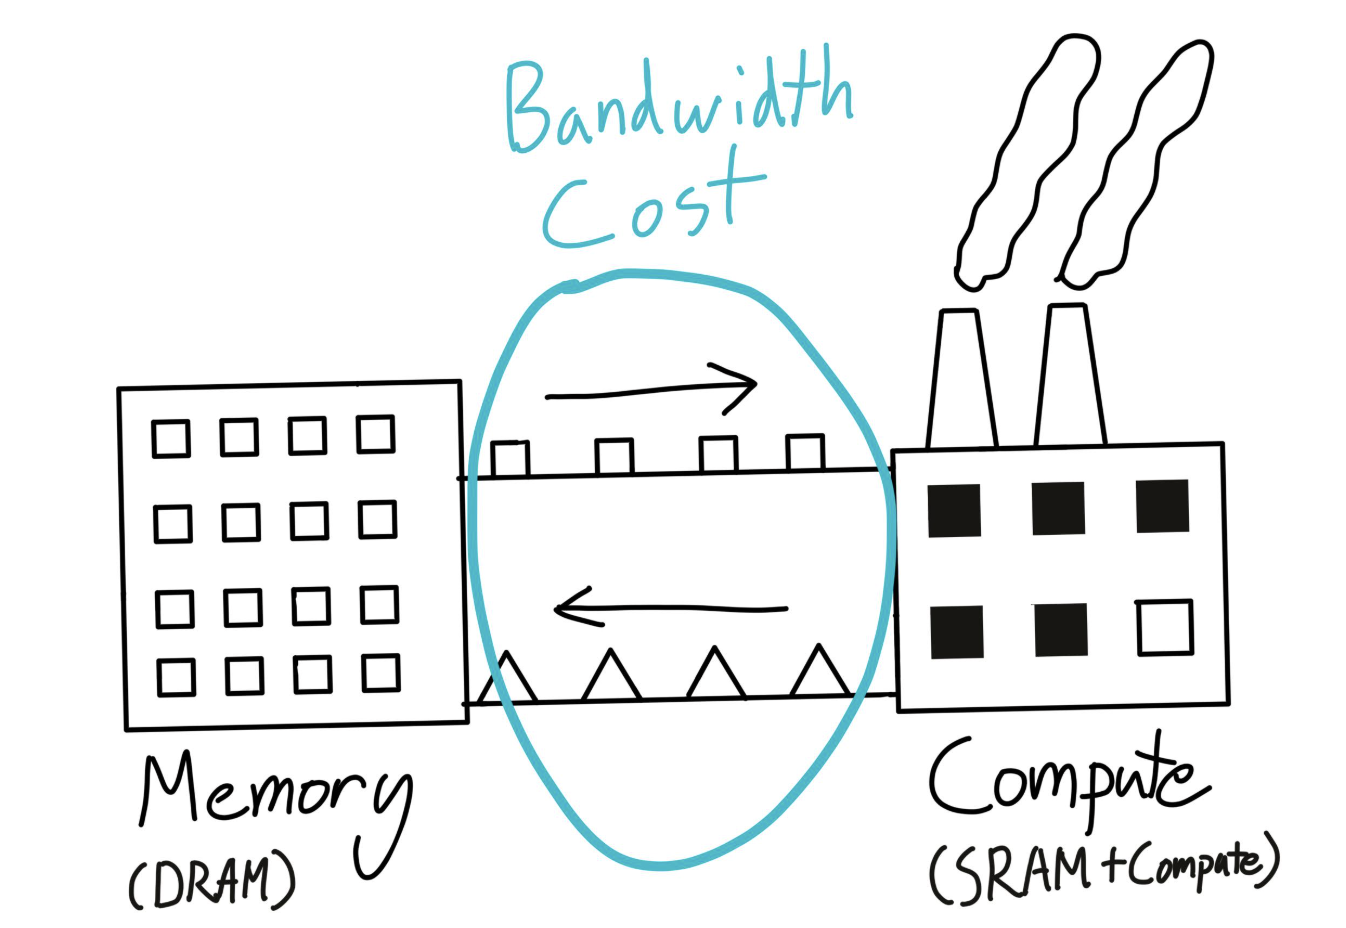

Now, imagine what happens when we perform an unary operation like `torch.cos`. We need to ship our data from our storage to the warehouse, then perform a tiny bit of computation for each piece of data, and then ship that storage back. Shipping things around is quite expensive. As a result, nearly all of our time here is spent shipping data around, and not on the actual computation itself.

Since we're spending all of our time on memory-bandwidth, such an operation is called a memory-bound operation, and it means that we're not spending a lot of time on compute.

Ok, so that's not ideal. What can we do about it? Let's take a look at how a sequence of operators might look.

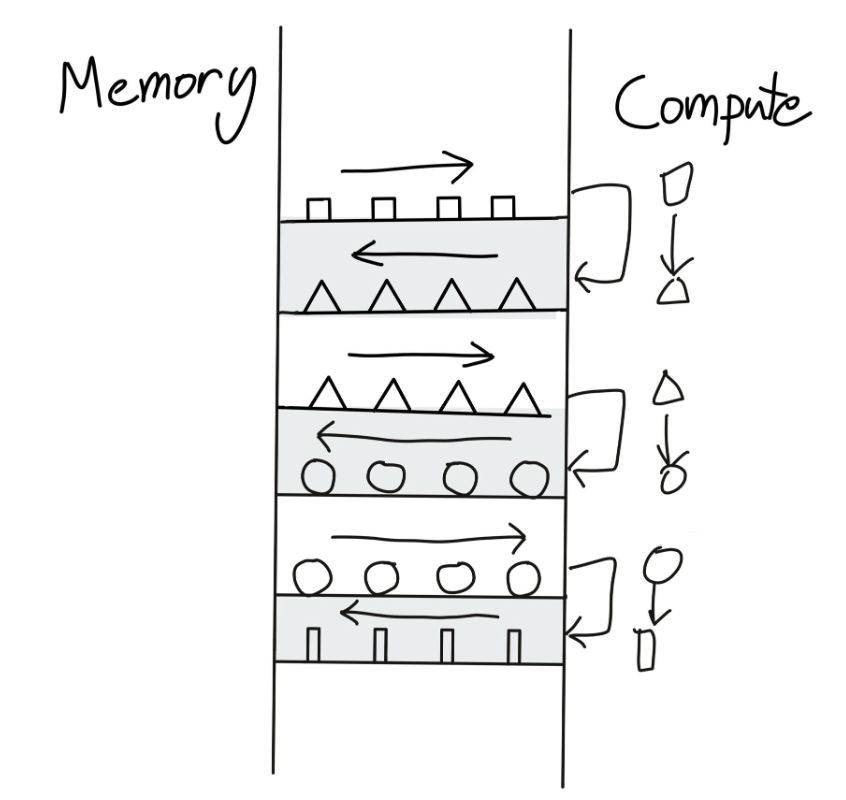

This is a very stupid arrangement. Why are we sending the same data to global memory and then back to the compute units, over and over? We should just keep the data at the factory, perform all of our compute, and then send it back! That's actually the spirit of fusion.

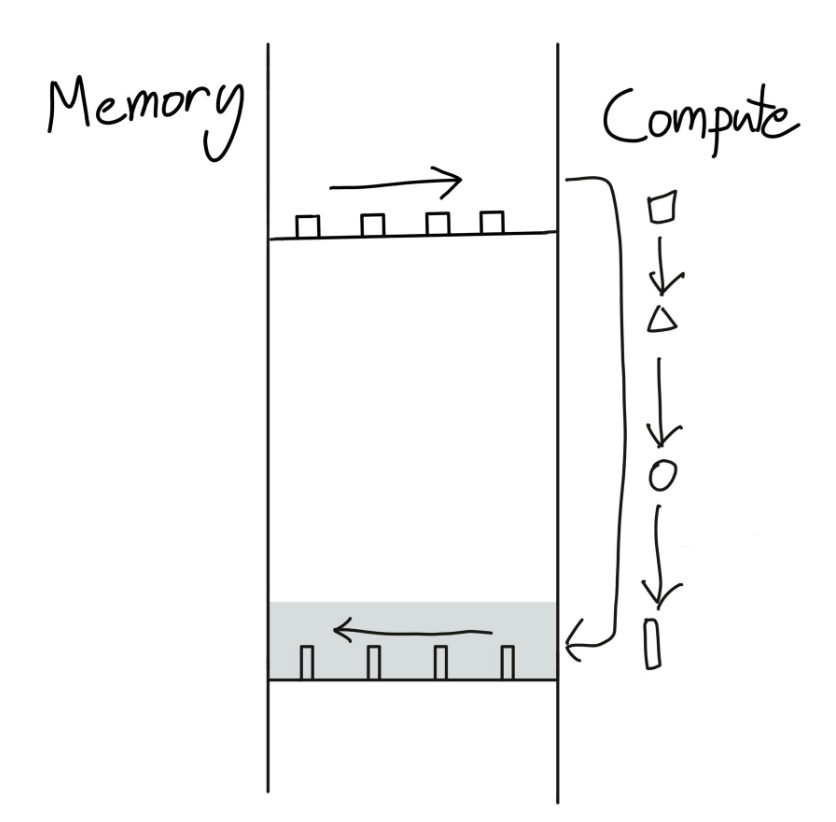

Now, let's see the actual speedup that kernel fusion can bring to us.

#### Question 4.3.1 (3 points)

Here is the mathematical equation of the GeLU activation function:

$$\text{GELU}(x) \approx 0.5x\left[1 + \tanh\left(\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)\right)\right]$$

Please implement this function using PyTorch. You can only use torch API for tanh and math operations such as power and square root.


In [10]:
def gelu_tanh_python(input):
    """
    Args:
        input (torch.Tensor): Input tensor to apply tanh-approximated GeLU.
    Returns:
        torch.Tensor: Output tensor after GeLU, same shape/dtype/device as input.
    """
    # YOUR CODE HERE
    sqrt_2_over_pi = math.sqrt(2.0 / math.pi)
    return 0.5 * input * (1.0 + torch.tanh(sqrt_2_over_pi * (input + 0.044715 * input ** 3)))
    # raise NotImplementedError()


#### Question 4.3.2 (2 points)

Benchmark the latency of your GeLU and PyTorch implemented GeLU.

In [11]:
# Benchmark the latency of your GeLU and PyTorch implemented GeLU. Use torch.nn.functional.gelu(x, approximate="tanh") for the PyTorch GeLU.
x = torch.randn(1000000, device="cuda")

# YOUR CODE HERE
python_gelu_latency = latency(gelu_tanh_python, x) * 1000 
pytorch_gelu_latency = latency(torch.nn.functional.gelu, x, approximate="tanh") * 1000
# raise NotImplementedError()

print(f"Python GeLU latency: {python_gelu_latency:.6f} ms")
print(f"PyTorch GeLU latency: {pytorch_gelu_latency:.6f} ms")


Python GeLU latency: 0.095892 ms
PyTorch GeLU latency: 0.018166 ms


#### Question 4.3.3 (2 points)
Describe your findings

**Your Answer:**

PyTorch's built-in GeLU is approximately 5.3× faster than the Python implementation (0.018ms vs 0.096ms). This significant performance gap exists because the Python implementation requires multiple separate CUDA kernel launches (one each for pow, mul, add, tanh operations), while PyTorch's version uses a single fused kernel that computes everything in one pass.

#### Question 4.3.4 (5 points)

Use PyTorch's profiler to explain your findings (please show your profiling code and results)

**Your Answer:**

> The profiler reveals the root cause of the performance difference:
> - Python GeLU: Shows 6-8 separate CUDA kernels (aten::pow, aten::mul, aten::add, aten::tanh, etc.). Each kernel launch has ~5-10μs overhead, and intermediate results must be written to and read from GPU memory between operations.
>
> - PyTorch GeLU: Shows only 1 fused kernel (aten::gelu). All computations happen in a single pass, keeping data in fast GPU registers and avoiding memory round-trips.
>
> The kernel launch overhead and memory bandwidth waste from multiple operations explain why the Python version is 5× slower despite doing the same mathematical computation.



In [12]:
# YOUR CODE HERE
print("Profiling Python Gelu") 

with profile(activities=[ProfilerActivity.CUDA], schedule=default_schedule) as prof_python:
    for _ in range(10):
        _ = gelu_tanh_python(x)
        prof_python.step()
    torch.cuda.synchronize()

print(prof_python.key_averages().table(sort_by="cuda_time_total", row_limit=15))

print("Profiling PyTorch GeLU (optimized)")

with profile(activities=[ProfilerActivity.CUDA], schedule=default_schedule) as prof_pytorch:
    for _ in range(10):
        _ = torch.nn.functional.gelu(x, approximate="tanh")
        prof_pytorch.step()
    torch.cuda.synchronize()

print(prof_pytorch.key_averages().table(sort_by="cuda_time_total", row_limit=15))

# Count kernels
python_kernels = len([e for e in prof_python.key_averages() if e.device_type.name == 'CUDA'])
pytorch_kernels = len([e for e in prof_pytorch.key_averages() if e.device_type.name == 'CUDA'])

print(f"\nPython GeLU: {python_kernels} kernel types")
print(f"PyTorch GeLU: {pytorch_kernels} kernel types")

# raise NotImplementedError()


Profiling Python Gelu
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us     158.402us        32.22%     158.402us       8.800us            18  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us      89.216us        18.15%      89.216us      14.869us    

## 4.4 `torch.compile` and CUDA Graph

torch.compile is PyTorch's way of speeding up your model by converting eager-mode Python code into optimized kernels. When you wrap a model with torch.compile(model), PyTorch traces the operations, fuses them where possible, and generates efficient Triton or C++ kernels behind the scenes. This reduces Python overhead and combines multiple small operations into fewer, larger kernels—meaning fewer kernel launches and better GPU utilization.

In the cell below, we first compile the GeLU function you just implemented and see how your GeLU is optimized.

In [13]:
compiled_gelu = torch.compile(gelu_tanh_python)

x = torch.randn(1000000, device="cuda")

with profile(schedule=default_schedule) as prof:
    for _ in range(10):
        _ = compiled_gelu(x)
        prof.step()
    torch.cuda.synchronize()

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

---------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          ProfilerStep*        37.70%     199.865us        99.19%     525.785us      87.631us       0.000us         0.00%      66.976us      11.163us             6  
                  Torch-Compiled Region        39.35%     208.580us        57.64%     305.570us      50.928us       0.000us         0.00%      66.976us      11.163us             6  
    triton_poi_fused_add_mul_pow_tanh_0         8.87%      47.000us        18.30%      96

Now, let's compile the MLP layer.

In [23]:
# compile the layer
mlp = Gemma3MLP(GEMMA3_270M_CONFIG).to(device=device, dtype=torch.bfloat16)
compiled_mlp = torch.compile(mlp, mode="max-autotune-no-cudagraphs")

#### Question 4.4.1 (3 points)

Profile the MLP again and describe the difference between the uncompiled version.

**Your Answer:**

> The compiled MLP (using torch.compile) shows significantly fewer kernel launches compared to the uncompiled version:
>
> - Uncompiled: Multiple separate kernels for gate_proj, up_proj, gelu, element-wise multiply, and down_proj (~5-7 kernels)
> - Compiled: Fused Triton kernels that combine multiple operations (~2-3 kernels)
>
> torch.compile automatically performs kernel fusion, combining operations like GeLU and element-wise multiplication into single optimized Triton kernels. This reduces kernel launch overhead and intermediate memory traffic, resulting in faster execution.

In [24]:
batch_size = 4
seq_len = 1024
hidden_size = GEMMA3_270M_CONFIG.hidden_size
x = torch.randn(batch_size, seq_len, hidden_size, device=device, dtype=torch.bfloat16)

# YOUR CODE HERE
mlp = Gemma3MLP(GEMMA3_270M_CONFIG).to(device=device, dtype=torch.bfloat16)
compiled_mlp = torch.compile(mlp, mode="max-autotune-no-cudagraphs")

# Warmup the compiled model (important - first run triggers compilation)
for _ in range(3):
    _ = compiled_mlp(x)
torch.cuda.synchronize()

# Profile the COMPILED MLP
print("Profiling COMPILED MLP (torch.compile)")
with profile(activities=[ProfilerActivity.CUDA], schedule=default_schedule) as prof:
    for _ in range(10):
        _ = compiled_mlp(x)
        prof.step()
    torch.cuda.synchronize()

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))
# raise NotImplementedError()


E0127 02:23:29.499000 1640 site-packages/torch/_inductor/select_algorithm.py:1300] [1/0] Exception out of resource: shared memory, Required: 147456, Hardware limit: 101376. Reducing block sizes or `num_stages` may help. for benchmark choice TritonTemplateCaller(/tmp/torchinductor_jovyan/n4/cn46wvacndgxbyxtoa4z4r3olboxnlspcge5asqvijxcviy7qvvc.py, ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=128, BLOCK_M=64, BLOCK_N=128, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=4, num_warps=4)
E0127 02:23:30.387000 1640 site-packages/torch/_inductor/select_algorithm.py:1300] [1/0] Exception out of resource: shared memory, Required: 131072, Hardware limit: 101376. Reducing block sizes or `num_stages` may help. for benchmark choice TritonTemplateCaller(/tmp/torchinductor_jovyan/jx/cjxqrxwe6xgscofkrv4yi6mxya6y67ue7ckynvmwqdkmej67x4sj.py, ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=128, BLOCK_M=64, BLOCK_N=64, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=5, num_

Profiling COMPILED MLP (torch.compile)
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  triton_         0.00%       0.000us         0.00%       0.000us       0.000us       2.318ms       100.00%       2.318ms      82.782us            28  
           cuLaunchKernel        12.25%     134.562us        12.25%     134.562us       5.607us       0.000us         0.00%       0.000us       0.000us            24  
    cudaDeviceSynchronize        87.75%     963.822us        87.75%     963.822us     963.822us       0.000us         0.

[W127 02:23:39.393303764 collection.cpp:634] Warning: triton_ (function operator())


torch.compile reduces the number of kernel launches by fusing operations, but the CPU still has to dispatch each remaining kernel individually every forward pass. CUDA graphs go further by recording the entire launch sequence once, then replaying it with a single CPU call. This means the CPU spends almost no time on launch overhead—it just triggers the whole graph.

In [25]:
mlp = Gemma3MLP(GEMMA3_270M_CONFIG).to(device=device, dtype=torch.bfloat16)
# compile the layer with CUDA Graphs
mlp = torch.compile(mlp, mode="max-autotune")

batch_size = 4
seq_len = 1024
hidden_size = GEMMA3_270M_CONFIG.hidden_size
x = torch.randn(batch_size, seq_len, hidden_size, device=device, dtype=torch.bfloat16)
x = mlp(x)

#### Bonus 4.4.2 (5 points)

Profile the MLP compiled with CUDA again and show the timeline visualization below.

In [27]:
# YOUR CODE HERE# Create and compile with CUDA Graphs
mlp = Gemma3MLP(GEMMA3_270M_CONFIG).to(device=device, dtype=torch.bfloat16)
compiled_mlp_cuda_graphs = torch.compile(mlp, mode="max-autotune")  # Includes CUDA Graphs

# Warmup (IMPORTANT - this triggers graph capture)
for _ in range(5):
    _ = compiled_mlp_cuda_graphs(x)
torch.cuda.synchronize()

# Profile with trace export for timeline visualization
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    schedule=default_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./cuda_graphs_profile'),
    record_shapes=True,
    with_stack=True
) as prof:
    for _ in range(10):
        _ = compiled_mlp_cuda_graphs(x)
        prof.step()
    torch.cuda.synchronize()

# Print summary
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))
# raise NotImplementedError()


-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  ProfilerStep*         0.00%       0.000us         0.00%       0.000us       0.000us       2.127ms       100.62%       2.127ms     354.417us             6  
          Torch-Compiled Region         4.34%     336.409us        96.75%       7.506ms       1.251ms       0.000us         0.00%       2.113ms     352.220us             6  
               CompiledFunction        83.08%       6.446ms        92.42%       7.170ms       1.195ms       0.000us         0.00%

# Part 5: Flash Attention

In this section, we will learn flash attention and know how it improves the standard attention.

**IMPORTANT: This section is now a bonus module because it cannot be executed on the standard Colab T4 GPU. We have made this change to ensure you don't face GPU availability issues as the deadline approaches. However, we highly encourage you to explore it if you have the resources; Flash Attention is a pivotal technique in the modern LLM era.**


## 5.1 Limitation of SDPA

Now, let's see what's the limitation of the standard scale-dot-product attention (SDPA).

In [28]:
for seq_len in [512, 1024, 2048, 4096, 8192, 16384, 32768]:
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    q = torch.randn(1, 16, seq_len, 128, dtype=torch.float16, device="cuda")
    k = torch.randn(1, 16, seq_len, 128, dtype=torch.float16, device="cuda")
    v = torch.randn(1, 16, seq_len, 128, dtype=torch.float16, device="cuda")

    try:
        mem, _ = benchmark_memory(scaled_dot_product_attention, q, k, v, n_warmup=3, n_repeat=10)
        attn_matrix_size = 1 * 16 * seq_len * seq_len * 2 / 1e9  # theoretical
        print(f"  seq_len={seq_len:5d}: {mem:.2f} GB (attn matrix: {attn_matrix_size:.2f} GB)")
    except torch.cuda.OutOfMemoryError:
        print(f"  seq_len={seq_len:5d}: OOM!")

    del q, k, v
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

  seq_len=  512: 0.17 GB (attn matrix: 0.01 GB)
  seq_len= 1024: 0.18 GB (attn matrix: 0.03 GB)
  seq_len= 2048: 0.40 GB (attn matrix: 0.13 GB)
  seq_len= 4096: 1.23 GB (attn matrix: 0.54 GB)
  seq_len= 8192: 4.52 GB (attn matrix: 2.15 GB)
  seq_len=16384: 17.54 GB (attn matrix: 8.59 GB)
  seq_len=32768: OOM!


#### Bonus 5.1 (10 points)

1. What is the memory complexity of standard attention? (3 points)
2. At what sequence length does it become problematic on your GPU? (3 points)
3. What's a major memory overhead of SDPA? And thus, in which LLM scenario could this be a big trouble? (4 points)

**Your Answer:**

> 1. Standard attention has 𝑂(𝐿^2) memory complexity due to storing the full attention matrix.
> 2. It becomes problematic at long sequences (around 4k–8k tokens), where memory usage grows rapidly and can exceed GPU memory limits (as seen in the figure in the next section near 8192)
> 3. A major overhead is storing large intermediate attention tensors during training. This is especially problematic for long-context LLM training or fine-tuning, where sequence lengths are large and memory quickly becomes a bottleneck

## 5.2 Flash Attention

Flash Attention is an algorithm that computes exact self-attention while being both faster and more memory-efficient than the standard implementation.

**Standard Attention Approach:**
Standard attention computes $\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d}})V$ by first materializing the full $N \times N$ attention matrix $S = QK^T$ in GPU high-bandwidth memory (HBM), then computing softmax row-wise, and finally multiplying by $V$. For long sequences, this $O(N^2)$ memory becomes prohibitive.

**Flash Attention Strategy:**
Flash Attention avoids materializing the full attention matrix by using tiling and kernel fusion. It divides $Q$, $K$, and $V$ into blocks that fit in GPU SRAM (on-chip fast memory), computes attention block-by-block without storing the full matrix in HBM (off-chip slow memory), and uses online softmax computation to maintain numerical stability across tiles. The key insight is to recompute intermediate values in SRAM rather than loading them from HBM, trading cheap recomputation for expensive memory I/O.

**Main improvements:**
- Memory reduction from $O(N^2)$ to $O(N)$, enabling longer sequence lengths
- 2-4x speedup by minimizing HBM accesses, which are the primary bottleneck on modern GPUs
- Exact attention computation with no approximation

If you know basic Triton or CUDA programming, we strongly suggest you read the kernel implementation [here](https://github.com/Dao-AILab/flash-attention). Here is the algorithm of flash attention.

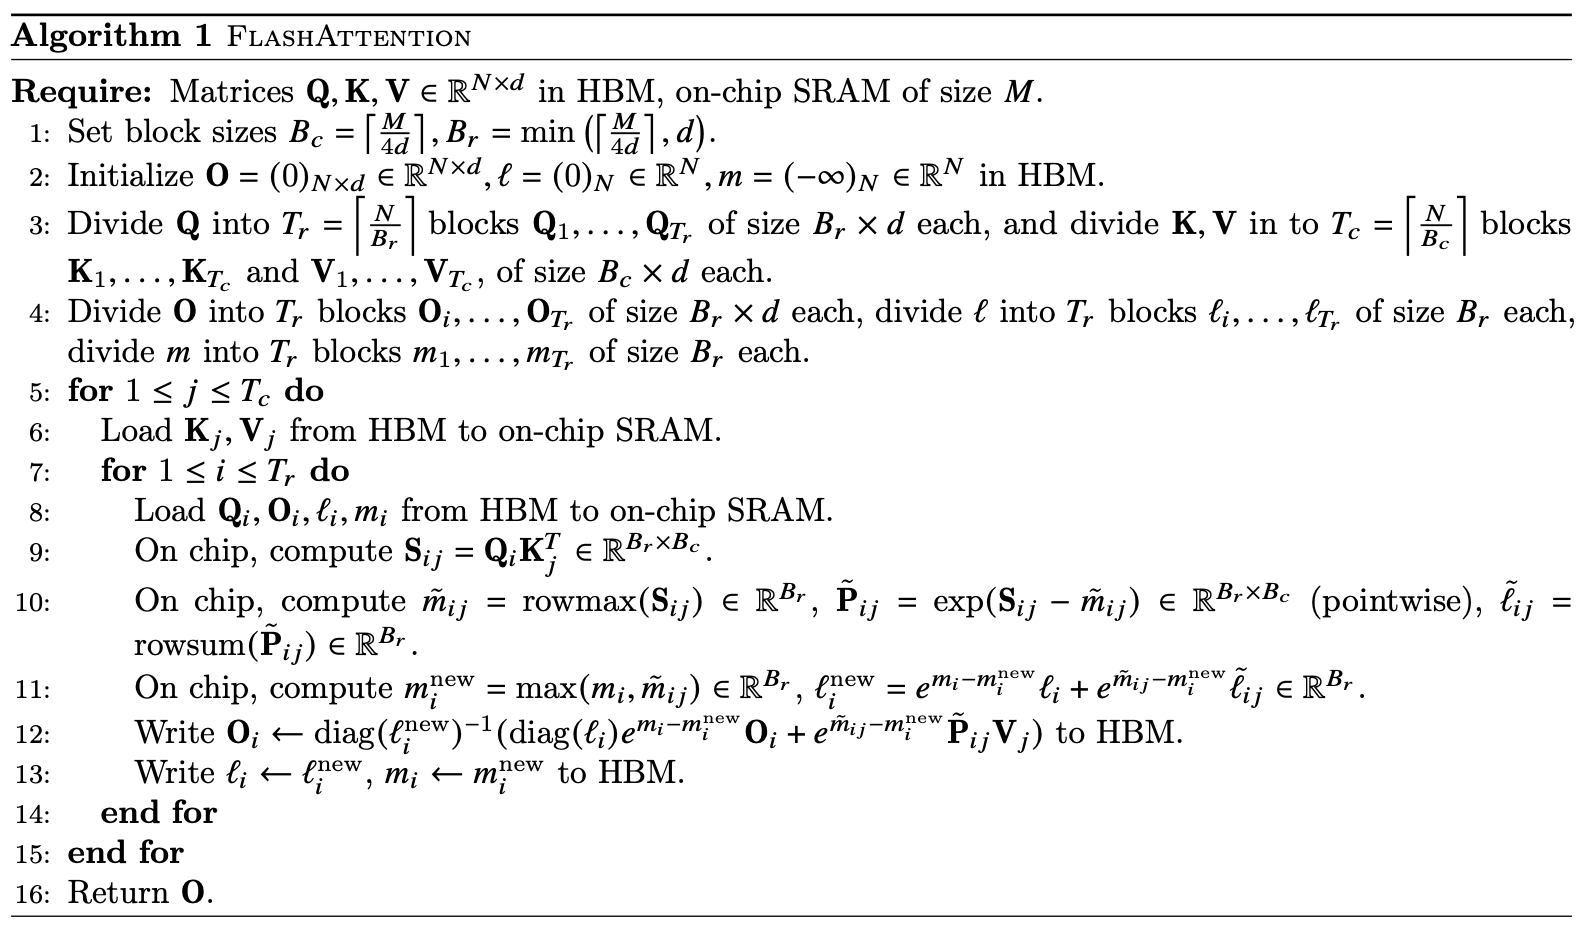

Now, let's do some basic benchmarking and compare flash attention with standard attention.

 seq_len   sdpa_ms  flash_ms  speedup  sdpa_mem_gb  flash_mem_gb
     256  0.115555  0.128266 0.900906     0.104498      0.104548
     512  0.131549  0.118662 1.108597     0.124421      0.107677
    1024  0.310531  0.168006 1.848330     0.190424      0.123381
    2048  1.484787  0.431418 3.441647     0.421110      0.152806
    4096  4.140368  1.358986 3.046661     1.284146      0.210667
    8192 15.872431  4.971475 3.192700     4.622812      0.328370


(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'Latency'}, xlabel='seq_len', ylabel='Latency (ms)'>,
        <Axes: title={'center': 'Memory'}, xlabel='seq_len', ylabel='Peak memory (GB)'>],
       dtype=object))

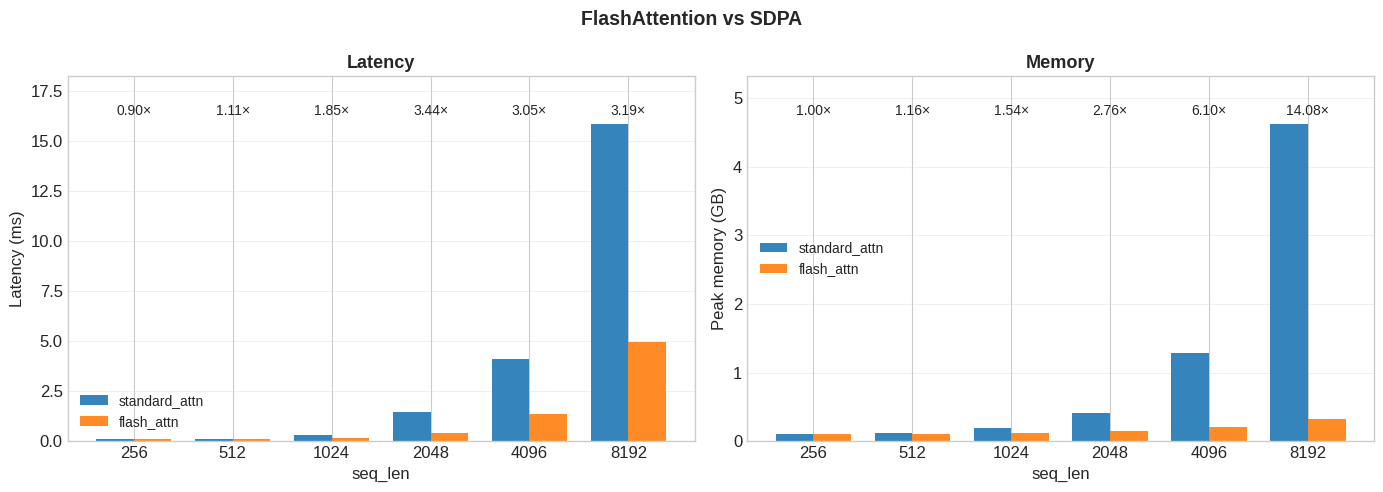

In [29]:
from flash_attn import flash_attn_func

results = []

for seq_len in [256, 512, 1024, 2048, 4096, 8192]:
    # Standard attention uses (B, H, L, D) format
    # Flash attention uses (B, L, H, D) format
    q_sdpa = torch.randn(1, 16, seq_len, 128, dtype=torch.float16, device="cuda")
    k_sdpa = torch.randn(1, 16, seq_len, 128, dtype=torch.float16, device="cuda")
    v_sdpa = torch.randn(1, 16, seq_len, 128, dtype=torch.float16, device="cuda")

    q_flash = q_sdpa.transpose(1, 2).contiguous()  # (B, S, H, D)
    k_flash = k_sdpa.transpose(1, 2).contiguous()
    v_flash = v_sdpa.transpose(1, 2).contiguous()

    # Benchmark standard
    torch.cuda.reset_peak_memory_stats()
    sdpa_time = benchmark_latency(scaled_dot_product_attention, q_sdpa, k_sdpa, v_sdpa, n_warmup=3, n_repeat=10)
    # std_mem = torch.cuda.max_memory_allocated() / 1e9
    sdpa_mem, _ = benchmark_memory(scaled_dot_product_attention, q_sdpa, k_sdpa, v_sdpa, n_warmup=3, n_repeat=10)

    # Benchmark flash
    torch.cuda.reset_peak_memory_stats()
    flash_time = benchmark_latency(flash_attn_func, q_flash, k_flash, v_flash, n_warmup=3, n_repeat=10)
    # flash_mem = torch.cuda.max_memory_allocated() / 1e9
    flash_mem, _ = benchmark_memory(flash_attn_func, q_flash, k_flash, v_flash, n_warmup=3, n_repeat=10)

    results.append({
        "seq_len": seq_len,
        "sdpa_ms": sdpa_time if sdpa_time != float('inf') else None,
        "flash_ms": flash_time,
        "speedup": sdpa_time / flash_time if sdpa_time != float('inf') else None,
        "sdpa_mem_gb": sdpa_mem if sdpa_mem != float('inf') else None,
        "flash_mem_gb": flash_mem,
    })

    del q_sdpa, k_sdpa, v_sdpa, q_flash, k_flash, v_flash
    torch.cuda.empty_cache()

df_flash = pd.DataFrame(results)
print(df_flash.to_string(index=False))
plot_flash_attn_improvement(
    df = df_flash,
    title = "FlashAttention vs SDPA",
    latency_cols = ("sdpa_ms", "flash_ms"),
    memory_cols = ("sdpa_mem_gb", "flash_mem_gb"),
    seq_len_col = "seq_len",
    annotate_speedup = True,
    annotate_mem_reduction = True
)

Let's use the profiler we just learned to see how flash attention reduces kernels by fusing the attention operation into one joint kernel. (Note that if you encounter negative results, you can restart the notebook kernel and rerun this cell)

In [ ]:
from torch.profiler import ProfilerActivity, profile

# Directly profiling the flash_attn_func is not stable, so we use the PyTorch implementation of
# flash attention which is integrated in torch.nn.functional.scaled_dot_product_attention
def torch_flash_attn(q, k, v):
    """
    Args:
        q (torch.Tensor): Query tensor in (B, S, H, D) format for flash attention.
        k (torch.Tensor): Key tensor in (B, S, H, D) format.
        v (torch.Tensor): Value tensor in (B, S, H, D) format.
    Returns:
        torch.Tensor: Flash attention output with shape (B, S, H, D).
    """
    return torch.nn.functional.scaled_dot_product_attention(q, k, v)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

seq_len = 1024
q_sdpa = torch.randn(2, 12, seq_len, 128, dtype=torch.bfloat16, device="cuda")
k_sdpa = torch.randn(2, 12, seq_len, 128, dtype=torch.bfloat16, device="cuda")
v_sdpa = torch.randn(2, 12, seq_len, 128, dtype=torch.bfloat16, device="cuda")
q_flash = q_sdpa.transpose(1, 2).contiguous()
k_flash = k_sdpa.transpose(1, 2).contiguous()
v_flash = v_sdpa.transpose(1, 2).contiguous()

# Profile standard
with profile(activities=[ProfilerActivity.CUDA], schedule=default_schedule) as prof_sdpa:
    with torch.no_grad():
        for _ in range(10):
            _ = scaled_dot_product_attention(q_sdpa, k_sdpa, v_sdpa)
            prof_sdpa.step()
    torch.cuda.synchronize()

# Profile flash
with profile(activities=[ProfilerActivity.CUDA], schedule=default_schedule) as prof_flash:
    with torch.no_grad():
        for _ in range(10):
            _ = torch_flash_attn(q_flash, k_flash, v_flash)
            prof_flash.step()
    torch.cuda.synchronize()

sdpa_kernels = count_cuda_kernels(prof_sdpa)
flash_kernels = count_cuda_kernels(prof_flash)

print(f"SDPA: {sdpa_kernels['total']} kernels")
print(f"Flash Attention: {flash_kernels['total']} kernels")
print(f"\nKernel fusion reduces {sdpa_kernels['total'] - flash_kernels['total']} kernel launches!")

#### Bonus 5.2 (10 points)

Based on our profiling and analysis above, please answer the following questions:

1. Why is standard attention memory-bound? (3 points)
2. How does Flash Attention make attention more compute-bound? (4 points)
3. Why does the speedup increase with sequence length? (3 points)

**Your Answer:**

> 1. Standard attention materializes the full 𝑂(𝐿^2)attention matrix and performs many global memory reads and writes, so memory bandwidth becomes the bottleneck rather than computation
> 2. Flash Attention avoids storing the full attention matrix, uses tiling and kernel fusion, and keeps data in on-chip memory, greatly reducing global memory access and increasing arithmetic intensity.
> 3. As sequence length grows, standard attention’s memory cost scales as 𝑂(𝐿^2), while Flash Attention reduces memory traffic, so the performance gap widens at longer sequences.

# Summary

In this lab, you learned:

1. **Latency, MAC&FLOPs, I/O**: How to calculate theoretical computational requirements
2. **Roofline Model**: How to identify compute vs memory bottlenecks
3. **Profiling**: How to use PyTorch Profiler to measure actual performance
4. **Kernel Optimization**: How kernel fusion, torch.compile, and CUDA Graphs reduce overhead
5. **Flash Attention**: How algorithmic improvements can dramatically improve efficiency